lin reg relationships

## importlibs

### run this to import and init ict class

In [1]:
## run this to import and initialize all the libraries ICT Class
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
import datetime
import threading
import os
import concurrent.futures
from numba import njit
import talib
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import GOOG
import plotly
import datetime as dt
import quantstats as qs
import statsmodels as sm
import sklearn as sk
import statsmodels.api as sm
import sklearn.metrics as skm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, RocCurveDisplay, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier



class ICT:
    def __init__(self, data):
        # Ensure 'ts_event' column exists and convert its type and set as index
        if 'ts_event' in data.columns:
            data['ts_event'] = pd.to_datetime(data['ts_event'])
            data.set_index('ts_event', inplace=True)
        
        self.data = data
        # Reset index if necessary or perform other initial data manipulations
        # self.data.reset_index(drop=True, inplace=True) 
        # Note: You might not want to drop the index if you've just set it

    def pump(self):
        movement = ((self.data['Close'] - self.data['Open']) / self.data['Open']) * 100
        self.data['pump_move'] = movement
        return movement > 0

    def dump(self):
        movement = ((self.data['Open'] - self.data['Close']) / self.data['Open']) * 100
        self.data['dump_move'] = movement
        return movement > 0

    def shigh(self):
        condition = self.shigh_condition()
        self.data['shigh_price'] = self.data['High'][condition]
        return condition

    def slow(self):
        condition = self.slow_condition()
        self.data['slow_price'] = self.data['Low'][condition]
        return condition

    def bisob(self):
        condition = self.slow_condition()
        self.data['bisob_open'] = self.data['Open'].shift(1)[condition]
        return condition

    def sibob(self):
        condition = self.shigh_condition()
        self.data['sibob_open'] = self.data['Open'].shift(1)[condition]
        return condition

    def bisi(self):
        bisi_indices = ICT.calculate_bisi_njit(self.data['Low'].to_numpy(), self.data['High'].to_numpy())
        bisi_series = pd.Series(False, index=self.data.index)
        bisi_series.iloc[bisi_indices] = True
        self.data['bisi_high'] = self.data['High'][bisi_series]
        self.data['bisi_low'] = self.data['Low'][bisi_series]
        return bisi_series

    def sibi(self):
        sibi_indices = ICT.calculate_sibi_njit(self.data['Low'].to_numpy(), self.data['High'].to_numpy())
        sibi_series = pd.Series(False, index=self.data.index)
        sibi_series.iloc[sibi_indices] = True
        self.data['sibi_low'] = self.data['Low'][sibi_series]
        self.data['sibi_high'] = self.data['High'][sibi_series]
        return sibi_series
    

    def dwHigh(self):
        """
        Create or update the 'dumpwickHO' column based on 'dump_move'.
        If 'dump_move' is positive, concatenate 'High' and 'Open' with a comma.
        Otherwise, set to 'NaN'.
        """
        self.data['dumpwickH'] = np.where(
            self.data['dump_move'] > 0,
            self.data['High'].astype(float),
            np.nan  # Use np.nan for consistency with pandas' handling of missing data
        )
    def dwOpen(self):
        """
        Create or update the 'dumpwickHO' column based on 'dump_move'.
        If 'dump_move' is positive, concatenate 'High' and 'Open' with a comma.
        Otherwise, set to 'NaN'.
        """
        self.data['dumpwickO'] = np.where(
            self.data['dump_move'] > 0,
            self.data['Open'].astype(float),
            np.nan  # Use np.nan for consistency with pandas' handling of missing data
        )
    def dumpwickHO(self):
        """
        Create or update the 'dumpwickHO' column based on 'dump_move'.
        If 'dump_move' is positive, concatenate 'High' and 'Open' with a comma.
        Otherwise, set to 'NaN'.
        """
        self.data['dumpwickHO'] = np.where(
            self.data['dump_move'] > 0,
            self.data['High'].astype(str) + ',' + self.data['Open'].astype(str),
            np.nan  # Use np.nan for consistency with pandas' handling of missing data
        )


    def pwOpen(self):
        """
        Create or update the 'dumpwickHO' column based on 'dump_move'.
        If 'dump_move' is positive, concatenate 'High' and 'Open' with a comma.
        Otherwise, set to 'NaN'.
        """
        self.data['pumpwickO'] = np.where(
            self.data['pump_move'] > 0,
            self.data['Open'].astype(float) ,
            np.nan
          )  # Use np.nan for consistency with pandas' handling of missing data
    def pwLow(self):
        """
        Create or update the 'dumpwickHO' column based on 'dump_move'.
        If 'dump_move' is positive, concatenate 'High' and 'Open' with a comma.
        Otherwise, set to 'NaN'.
        """
        self.data['pumpwickL'] = np.where(
            self.data['pump_move'] > 0,
            self.data['Low'],
            np.nan
          )  # Use np.nan for consistency with pandas' handling of missing data
    def pumpwickOL(self):
        """
        Create or update the 'dumpwickHO' column based on 'dump_move'.
        If 'dump_move' is positive, concatenate 'High' and 'Open' with a comma.
        Otherwise, set to 'NaN'.
        """
        self.data['pumpwickOL'] = np.where(
            self.data['pump_move'] > 0,
            self.data['Open'].astype(str) + ',' + self.data['Low'].astype(str),
            np.nan  # Use np.nan for consistency with pandas' handling of missing data
        )
    def ce(self, value1, value2):
        """
        Calculate the mean of two values.
        
        Parameters:
        value1 (float): The first value.
        value2 (float): The second value.
        
        Returns:
        float: The mean of value1 and value2.
        """
        return (value1 + value2) / 2
        

    def qurt(self, value1, value2):
        """
        Divides the range between two values into quartiles.
        """
        quartiles = np.quantile(np.linspace(value1, value2, num=100), [0.25, 0.5, 0.75])
        return quartiles

    def std1(self, series):
        """
        Calculates 1 standard deviation for the given series.
        """
        return np.std(series)
    
    def std2(self, series):
        """
        Calculates 2 standard deviations for the given series.
        """
        return np.std(series) * 2
    
    def std3(self, series):
        """
        Calculates 3 standard deviations for the given series.
        """
        return np.std(series) * 3


    def adr(self, n_periods, freq):
        """
        Calculates the Average Day Range (ADR) for the asset, anchored at midnight.
        
        :param n_periods: Number of periods to calculate the average range. Defaults to 14.
        :param freq: Frequency of the periods (e.g., 'D' for days, '4H' for 4-hour candles, '15T' for 15-minute candles).
        :return: DataFrame with ADR values.
        """
        # If the data index is not a DatetimeIndex, this method should either convert it or raise an error
        if not isinstance(self.data.index, pd.DatetimeIndex):
            raise TypeError("DataFrame index must be a DatetimeIndex.")
        freq = '4H'
        n_periods = 6
        # Ensure the data's datetime index starts at midnight by normalizing the index
        self.data.index = self.data.index.normalize()
        
        # If data is not daily, resample it according to the specified frequency
        if freq != '4H':
            # The actual resampling, ensuring it starts at midnight
            self.data = self.data.resample(freq).agg({'High': 'max', 'Low': 'min'})
        
        # Calculate the range (High - Low) for each period
        self.data['Range'] = self.data['High'] - self.data['Low']
        
        # Calculate the ADR as the average of the range over the specified number of periods
        self.data['ADR'] = self.data['Range'].rolling(window=n_periods).mean()

        return self.data[['ADR']]
    

    def fvg_ce(self):
        """
        Calculates the center points ('bisi_ce' and 'sibi_ce') for bisi and sibi signals.
        """
        self.data['bisi_ce'] = np.where(
            self.data['bisi_high'] > self.data['bisi_low'],
            (self.data['bisi_high'] + self.data['bisi_low']) / 2,
            np.nan
        )
        self.data['sibi_ce'] = np.where(
            self.data['sibi_high'] > self.data['sibi_low'],
            (self.data['sibi_high'] + self.data['sibi_low']) / 2,
            np.nan
        )


    
    @staticmethod
    @njit
    def calculate_bisi_njit(Low, High):
        bisi_indices = []
        for i in range(1, len(Low) - 1):
            if High[i - 1] < Low[i + 1]:
                bisi_indices.append(i)
        return np.array(bisi_indices)

    def calculate_bisi(self):
        Low = self.data['Low'].to_numpy()
        High = self.data['High'].to_numpy()
        bisi_indices = ICT.calculate_bisi_njit(Low, High)

        # Create a Boolean series with the same length as the DataFrame
        bisi_series = pd.Series(False, index=self.data.index)
        bisi_series.iloc[bisi_indices] = True
        return bisi_series

    @staticmethod
    @njit
    def calculate_sibi_njit(Low, High):
        sibi_indices = []
        for i in range(1, len(Low) - 1):
            if Low[i - 1] > High[i + 1]:
                sibi_indices.append(i)
        return np.array(sibi_indices)

    def calculate_sibi(self):
        Low = self.data['Low'].to_numpy()
        High = self.data['High'].to_numpy()
        sibi_indices = ICT.calculate_sibi_njit(Low, High)

        # Create a Boolean series with the same length as the DataFrame
        sibi_series = pd.Series(False, index=self.data.index)
        sibi_series.iloc[sibi_indices] = True
        return sibi_series

    # Helper methods for conditions
    def shigh_condition(self):
        high_shifted_minus_1 = self.data['High'].shift(-1)
        high_shifted_plus_1 = self.data['High'].shift(1)
        return (self.data['High'] > high_shifted_minus_1) & (self.data['High'] > high_shifted_plus_1)

    def slow_condition(self):
        low_shifted_minus_1 = self.data['Low'].shift(-1)
        low_shifted_plus_1 = self.data['Low'].shift(1)
        return (self.data['Low'] < low_shifted_minus_1) & (self.data['Low'] < low_shifted_plus_1)


c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporation\enigma\ict\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporation\enigma\ict\lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporation\enigma\ict\lib\site-packages\backtesting\test\__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it i

Insert data formed like this


	ts_event	open	high	low	close
0	2021-02-01 19:00:00-05:00	3769.75	3770.00	3760.25	3761.75

1	2021-02-01 19:15:00-05:00	3761.50	3765.25	3760.00	3761.75

2	2021-02-01 19:30:00-05:00	3761.50	3767.25	3760.00	3766.50

3	2021-02-01 19:45:00-05:00	3766.50	3767.25	3763.75	3767.25

4	2021-02-01 20:00:00-05:00	3767.25	3773.25	3766.25	3772.75


ts_event we have here is in NewYork time (EST), hence the -05:00 tz is aware
15minutes intervals(candles)

In [2]:

es15 = pd.read_csv('estick15min.csv')
es5 = pd.read_csv('estick5min.csv')
es30 = pd.read_csv('estick_30m.csv')
es60 = pd.read_csv('estick_60m.csv')
es240 = pd.read_csv('estick_240m.csv')
es1 = pd.read_csv('estick1m.csv')

In [3]:
es15

,ts_event,open,high,low,close
0,2021-02-01 19:00:00-05:00,3769.75,3770.00,3760.25,3761.75
1,2021-02-01 19:15:00-05:00,3761.50,3765.25,3760.00,3761.75
2,2021-02-01 19:30:00-05:00,3761.50,3767.25,3760.00,3766.50
3,2021-02-01 19:45:00-05:00,3766.50,3767.25,3763.75,3767.25
4,2021-02-01 20:00:00-05:00,3767.25,3773.25,3766.25,3772.75
...,...,...,...,...,...
35035,2022-02-01 17:45:00-05:00,NaN,NaN,NaN,NaN
35036,2022-02-01 18:00:00-05:00,4552.00,4552.25,4547.00,4548.75
35037,2022-02-01 18:15:00-05:00,4548.75,4552.25,4548.50,4551.75
35038,2022-02-01 18:30:00-05:00,4551.75,4552.25,4548.50,4552.25


can save ictdata to csv

In [64]:
#saveictdata tocsv
ict15data.to_csv('ict15data.csv', index=True)  # Replace 'index=True' with 'index=True' if you want to include the index
ict60data.to_csv('ict60data.csv', index=True)
ict5data.to_csv('ict5data.csv', index=True)
ict1data.to_csv('ict1data.csv', index=True)
ict240data.to_csv('ict240data.csv', index=True)


NameError: name 'ict15data' is not defined

process ict

In [4]:

def process_ict(csv_file):
    # Read the CSV file
    data = pd.read_csv(csv_file)
    
    # Convert 'ts_event' to datetime with UTC timezone and then to naive (timezone unaware)
    data['ts_event'] = pd.to_datetime(data['ts_event'], utc=True).dt.tz_localize(None)
    
    # # Forward fill NaNs for 'Open', 'High', 'Low', 'Close'
    # Set 'ts_event' as the index

    #     # # Rename the columns
    data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
    
    data[['Open', 'High', 'Low', 'Close']] = data[['Open', 'High', 'Low', 'Close']].ffill()
    # # Ensure 'Open', 'High', 'Low', 'Close' are of float64 type
    data = data.astype({'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close': 'float64'})
    data.set_index('ts_event', inplace=True)
    
    return data

# Now you can process each CSV file and store them into variables
es15 = process_ict('estick15min.csv')
es5 = process_ict('estick5min.csv')
es30 = process_ict('estick_30m.csv')
es60 = process_ict('estick_60m.csv')
es240 = process_ict('estick_240m.csv')
es1 = process_ict('estick1m.csv')

# Example usage
print(es5.head())  # This will print out the first few rows of the 'es5' DataFrame with 'ts_event' as DatetimeIndex


                        Open     High      Low    Close
ts_event                                               
2021-02-02 00:00:00  3769.75  3770.00  3767.00  3767.50
2021-02-02 00:05:00  3767.25  3768.25  3765.75  3766.25
2021-02-02 00:10:00  3766.00  3766.25  3760.25  3761.75
2021-02-02 00:15:00  3761.50  3765.00  3760.00  3764.75
2021-02-02 00:20:00  3765.00  3765.25  3761.75  3763.00


In [5]:
es5

,Open,High,Low,Close
ts_event,,,,
2021-02-02 00:00:00,3769.75,3770.00,3767.00,3767.50
2021-02-02 00:05:00,3767.25,3768.25,3765.75,3766.25
2021-02-02 00:10:00,3766.00,3766.25,3760.25,3761.75
2021-02-02 00:15:00,3761.50,3765.00,3760.00,3764.75
2021-02-02 00:20:00,3765.00,3765.25,3761.75,3763.00
...,...,...,...,...
2022-02-01 23:35:00,4550.00,4551.25,4548.75,4551.00
2022-02-01 23:40:00,4551.25,4552.25,4550.50,4552.25
2022-02-01 23:45:00,4552.00,4552.00,4550.25,4550.50


In [6]:
# Dictionary of DataFrames keyed by their timeframes
data_frames = {
    '15min': es15,
    '5min': es5,
    '30min': es30,
    '60min': es60,
    '240min': es240,
    '1min': es1
}

# Initialize ICT instances for each timeframe directly with the DataFrame
ict_instances = {tf: ICT(df) for tf, df in data_frames.items()}


# Now apply the methods as described
methods_to_apply = [
    'pump', 'dump', 'adr'
]

methods_with_args = {
    'adr': {'n_periods': 6, 'freq': '4H'}
}

for tf, ict_instance in ict_instances.items():
    # Call methods that don't require additional arguments
    for method_name in methods_to_apply:
        if method_name not in methods_with_args:
            getattr(ict_instance, method_name)()  # Call method without args

    # Now, call methods that require additional arguments
    for method_name, args in methods_with_args.items():
        if method_name in methods_to_apply:  # Ensure method is intended to be applied
            getattr(ict_instance, method_name)(**args)  # Call method with args


# Access modified data from each instance
ict_es15 = ict_instances['15min'].data
ict_es5 = ict_instances['5min'].data

# Example: print the first few rows of the modified data for 15min timeframe
print(ict_es15.head(6))

               Open     High      Low    Close  pump_move  dump_move  Range  \
ts_event                                                                      
2021-02-02  3769.75  3770.00  3760.25  3761.75  -0.212216   0.212216   9.75   
2021-02-02  3761.50  3765.25  3760.00  3761.75   0.006646  -0.006646   5.25   
2021-02-02  3761.50  3767.25  3760.00  3766.50   0.132926  -0.132926   7.25   
2021-02-02  3766.50  3767.25  3763.75  3767.25   0.019912  -0.019912   3.50   
2021-02-02  3767.25  3773.25  3766.25  3772.75   0.145995  -0.145995   7.00   
2021-02-02  3772.75  3783.25  3771.75  3782.25   0.251806  -0.251806  11.50   

              ADR  
ts_event           
2021-02-02    NaN  
2021-02-02    NaN  
2021-02-02    NaN  
2021-02-02    NaN  
2021-02-02    NaN  
2021-02-02  7.375  


In [7]:
print(ict_es15.head(22))

               Open     High      Low    Close  pump_move  dump_move  Range  \
ts_event                                                                      
2021-02-02  3769.75  3770.00  3760.25  3761.75  -0.212216   0.212216   9.75   
2021-02-02  3761.50  3765.25  3760.00  3761.75   0.006646  -0.006646   5.25   
2021-02-02  3761.50  3767.25  3760.00  3766.50   0.132926  -0.132926   7.25   
2021-02-02  3766.50  3767.25  3763.75  3767.25   0.019912  -0.019912   3.50   
2021-02-02  3767.25  3773.25  3766.25  3772.75   0.145995  -0.145995   7.00   
2021-02-02  3772.75  3783.25  3771.75  3782.25   0.251806  -0.251806  11.50   
2021-02-02  3782.25  3783.25  3780.25  3781.50  -0.019829   0.019829   3.00   
2021-02-02  3781.50  3787.75  3780.50  3786.00   0.119000  -0.119000   7.25   
2021-02-02  3786.00  3787.00  3781.25  3782.00  -0.105652   0.105652   5.75   
2021-02-02  3782.00  3787.75  3781.75  3786.25   0.112374  -0.112374   6.00   
2021-02-02  3786.50  3792.00  3786.50  3789.75   0.0

In [8]:
# Access modified data from each instance
ict_es30 = ict_instances['30min'].data
ict_es1 = ict_instances['1min'].data
ict_es60= ict_instances['60min'].data
ict_es240 = ict_instances['240min'].data
# Access modified data from each instance
ict_es15 = ict_instances['15min'].data
ict_es5 = ict_instances['5min'].data

In [9]:
ict_es30.head(40)

,Open,High,Low,Close,pump_move,dump_move,Range,ADR
ts_event,,,,,,,,
2021-02-02,3769.75,3770.00,3760.00,3761.75,-0.212216,0.212216,10.00,NaN
2021-02-02,3761.50,3767.25,3760.00,3767.25,0.152865,-0.152865,7.25,NaN
2021-02-02,3767.25,3783.25,3766.25,3782.25,0.398168,-0.398168,17.00,NaN
2021-02-02,3782.25,3787.75,3780.25,3786.00,0.099147,-0.099147,7.50,NaN
2021-02-02,3786.00,3787.75,3781.25,3786.25,0.006603,-0.006603,6.50,NaN
2021-02-02,3786.50,3792.00,3786.25,3787.00,0.013205,-0.013205,5.75,9.000000
2021-02-02,3787.25,3787.75,3783.75,3786.75,-0.013202,0.013202,4.00,8.000000
2021-02-02,3786.75,3787.75,3783.25,3786.75,0.000000,0.000000,4.50,7.541667
2021-02-02,3786.75,3787.75,3784.25,3785.75,-0.026408,0.026408,3.50,5.291667


## Draw on Liquidity

Up or Down

In [10]:
ictlist = [ict_es1, ict_es5, ict_es15, ict_es30, ict_es60, ict_es240]
ictlist2 = [ict_es1, ict_es5, ict_es15, ict_es30, ict_es60, ict_es240]

ictlist

[               Open     High      Low    Close  pump_move  dump_move  Range  \
 ts_event                                                                      
 2021-02-02  3769.75  3770.00  3767.75  3768.25  -0.039790   0.039790   2.25   
 2021-02-02  3768.00  3769.25  3767.25  3768.00   0.000000   0.000000   2.00   
 2021-02-02  3768.00  3768.50  3767.50  3768.25   0.006635  -0.006635   1.00   
 2021-02-02  3768.25  3768.50  3767.00  3768.00  -0.006634   0.006634   1.50   
 2021-02-02  3768.00  3768.00  3767.25  3767.50  -0.013270   0.013270   0.75   
 ...             ...      ...      ...      ...        ...        ...    ...   
 2022-02-01  4550.00  4550.25  4550.00  4550.25   0.005495  -0.005495   0.25   
 2022-02-01  4550.25  4550.75  4550.00  4550.50   0.005494  -0.005494   0.75   
 2022-02-01  4550.50  4550.75  4550.25  4550.75   0.005494  -0.005494   0.50   
 2022-02-01  4551.00  4551.00  4550.25  4551.00   0.000000   0.000000   0.75   
 2022-02-01  4551.00  4551.50  4551.00  

In [11]:
for df in ictlist:
    # Create 'pump' column, with 1 where 'pump_move' > 0, otherwise 0
    df['pump'] = np.where(df['pump_move'] > 0, 1, 0)
    
    # Similarly, create 'dump' column, with 1 where 'dump_move' > 0, otherwise 0
    df['dump'] = np.where(df['dump_move'] > 0, 1, 0)

In [12]:
ictlist[3]

,Open,High,Low,Close,pump_move,dump_move,Range,ADR,pump,dump
ts_event,,,,,,,,,,
2021-02-02,3769.75,3770.00,3760.00,3761.75,-0.212216,0.212216,10.00,NaN,0,1
2021-02-02,3761.50,3767.25,3760.00,3767.25,0.152865,-0.152865,7.25,NaN,1,0
2021-02-02,3767.25,3783.25,3766.25,3782.25,0.398168,-0.398168,17.00,NaN,1,0
2021-02-02,3782.25,3787.75,3780.25,3786.00,0.099147,-0.099147,7.50,NaN,1,0
2021-02-02,3786.00,3787.75,3781.25,3786.25,0.006603,-0.006603,6.50,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...
2022-02-01,4549.50,4554.75,4549.25,4549.50,0.000000,0.000000,5.50,13.916667,0,0
2022-02-01,4549.50,4554.75,4549.25,4549.50,0.000000,0.000000,5.50,12.625000,0,0
2022-02-01,4549.50,4554.75,4549.25,4549.50,0.000000,0.000000,5.50,12.166667,0,0


In [13]:
ictlist

[               Open     High      Low    Close  pump_move  dump_move  Range  \
 ts_event                                                                      
 2021-02-02  3769.75  3770.00  3767.75  3768.25  -0.039790   0.039790   2.25   
 2021-02-02  3768.00  3769.25  3767.25  3768.00   0.000000   0.000000   2.00   
 2021-02-02  3768.00  3768.50  3767.50  3768.25   0.006635  -0.006635   1.00   
 2021-02-02  3768.25  3768.50  3767.00  3768.00  -0.006634   0.006634   1.50   
 2021-02-02  3768.00  3768.00  3767.25  3767.50  -0.013270   0.013270   0.75   
 ...             ...      ...      ...      ...        ...        ...    ...   
 2022-02-01  4550.00  4550.25  4550.00  4550.25   0.005495  -0.005495   0.25   
 2022-02-01  4550.25  4550.75  4550.00  4550.50   0.005494  -0.005494   0.75   
 2022-02-01  4550.50  4550.75  4550.25  4550.75   0.005494  -0.005494   0.50   
 2022-02-01  4551.00  4551.00  4550.25  4551.00   0.000000   0.000000   0.75   
 2022-02-01  4551.00  4551.50  4551.00  

In [14]:
# Initialize an empty list to hold the modified Series
modified_series_list = []

for ict in ictlist:
    # Calculate the percentage change of the 'Close' column
    pct_change_series = ict['Close'].pct_change(fill_method=None) * 100
    
    # Rename the Series and reset its index
    pct_change_series = pct_change_series.rename("Today").reset_index()
    
    # Append the modified Series to the list
    modified_series_list.append(pct_change_series)

# Now `modified_series_list` contains all the modified Series with percentage changes


In [15]:
# Assuming ictlist is a list of DataFrames
for df in ictlist:
    # Loop to create 5 lagged features for the 'Today' column
    for i in range(1, 6):
        # Use `shift(i)` to create the lagged Series and assign it to a new column named 'Lag i'
        df['Lag ' + str(i)] = df['pump_move'].shift(i)


In [16]:
for df in ictlist:
    
    for i in range(1,6):
        df['RangeLag ' + str(i)] = df['Range'].shift(i)

In [17]:
for df in ictlist:
    df.dropna(inplace=True)

In [18]:
for ict in ictlist:
    # Predefined list of numeric columns
    numeric_cols = ['Range', 'ADR', 'Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 5', 'RangeLag 1', 'RangeLag 2', 'RangeLag 3', 'RangeLag 4', 'RangeLag 5', 'Close', 'Open', 'High', 'Low']
    
    # Dynamically identify categorical columns by excluding numeric columns and the 'target' column
    cat_cols = list(set(ict.columns) - set(numeric_cols) - {'pump', 'dump'})
    cat_cols.sort()  # Sort the categorical columns for consistent ordering

    # Print the columns for each DataFrame
    print("Numeric columns:", numeric_cols)
    print("Categorical columns:", cat_cols)
    print()  # Adds an empty line for better readability between DataFrame outputs


Numeric columns: ['Range', 'ADR', 'Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 5', 'RangeLag 1', 'RangeLag 2', 'RangeLag 3', 'RangeLag 4', 'RangeLag 5', 'Close', 'Open', 'High', 'Low']
Categorical columns: ['dump_move', 'pump_move']

Numeric columns: ['Range', 'ADR', 'Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 5', 'RangeLag 1', 'RangeLag 2', 'RangeLag 3', 'RangeLag 4', 'RangeLag 5', 'Close', 'Open', 'High', 'Low']
Categorical columns: ['dump_move', 'pump_move']

Numeric columns: ['Range', 'ADR', 'Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 5', 'RangeLag 1', 'RangeLag 2', 'RangeLag 3', 'RangeLag 4', 'RangeLag 5', 'Close', 'Open', 'High', 'Low']
Categorical columns: ['dump_move', 'pump_move']

Numeric columns: ['Range', 'ADR', 'Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 5', 'RangeLag 1', 'RangeLag 2', 'RangeLag 3', 'RangeLag 4', 'RangeLag 5', 'Close', 'Open', 'High', 'Low']
Categorical columns: ['dump_move', 'pump_move']

Numeric columns: ['Range', 'ADR', 'Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 5', '

In [19]:
len(ictlist)

6

In [20]:
for tf in modified_series_list:
    # Create the 'Direction' column based on the condition
    tf['Direction'] = np.where(tf['Today'] > 0, 1, 0)

In [21]:
print(modified_series_list)

[         ts_event     Today  Direction
0      2021-02-02       NaN          0
1      2021-02-02 -0.006634          0
2      2021-02-02  0.006635          1
3      2021-02-02 -0.006634          0
4      2021-02-02 -0.013270          0
...           ...       ...        ...
525595 2022-02-01  0.005495          1
525596 2022-02-01  0.005494          1
525597 2022-02-01  0.005494          1
525598 2022-02-01  0.005494          1
525599 2022-02-01  0.005493          1

[525600 rows x 3 columns],          ts_event     Today  Direction
0      2021-02-02       NaN          0
1      2021-02-02 -0.033179          0
2      2021-02-02 -0.119482          0
3      2021-02-02  0.079750          1
4      2021-02-02 -0.046484          0
...           ...       ...        ...
105115 2022-02-01  0.021978          1
105116 2022-02-01  0.027466          1
105117 2022-02-01 -0.038443          0
105118 2022-02-01 -0.010988          0
105119 2022-02-01  0.027473          1

[105120 rows x 3 columns],        

In [23]:
# Assuming modified_series_list is a list of pandas DataFrames
for i in range(len(ictlist)):
    # Add a constant to the DataFrame at index i
    ictlist[i] = sm.add_constant(ictlist[i])

In [24]:
ictlist

[            const     Open     High      Low    Close  pump_move  dump_move  \
 ts_event                                                                      
 2021-02-02    1.0  3767.25  3767.75  3766.75  3767.25   0.000000   0.000000   
 2021-02-02    1.0  3767.00  3768.25  3767.00  3767.75   0.019910  -0.019910   
 2021-02-02    1.0  3767.75  3768.25  3766.75  3767.00  -0.019906   0.019906   
 2021-02-02    1.0  3767.00  3767.00  3765.75  3766.25  -0.019910   0.019910   
 2021-02-02    1.0  3766.25  3767.50  3766.25  3766.25   0.000000   0.000000   
 ...           ...      ...      ...      ...      ...        ...        ...   
 2022-02-01    1.0  4550.00  4550.25  4550.00  4550.25   0.005495  -0.005495   
 2022-02-01    1.0  4550.25  4550.75  4550.00  4550.50   0.005494  -0.005494   
 2022-02-01    1.0  4550.50  4550.75  4550.25  4550.75   0.005494  -0.005494   
 2022-02-01    1.0  4551.00  4551.00  4550.25  4551.00   0.000000   0.000000   
 2022-02-01    1.0  4551.00  4551.50  45

In [25]:
ict3 = ictlist[3]

In [26]:
X1 = []  # Initialize empty list for features
y1 = []  # Initialize empty list for target (Pump)
y2 = []  # Initialize empty list for another target (Dump)



# Iterate over each DataFrame in the list
for ict in ictlist:
    # Enure 'Pump' and 'Dump' columns exist
    if 'pump' in ict.columns and 'dump' in ict.columns:
        # Append features to X1
        X1.append(ict[['const', 'Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 5', 'Range', 'RangeLag 1', 'RangeLag 2', 'RangeLag 3', 'RangeLag 4', 'RangeLag 5', 'pump', 'dump', 'ADR', 'pump_move', 'dump_move', 'Open', 'High', 'Low', 'Close']])
        # Append target to y1 and y2
        y1.append(ict['pump'])
        y2.append(ict['dump'])
    else:
        print("Missing 'Pump' or 'Dump' column in DataFrame.")

# After this, X1, y1, and y2 should be populated accordingly.|


In [122]:
ict3 = ictlist[3]


In [27]:
from sklearn.model_selection import train_test_split

# Extract feature and target arrays
X, y = ict3.drop('pump', axis=1), ict3[['pump']]

In [28]:
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')

In [29]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [30]:
import xgboost as xgb

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [31]:
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

In [32]:
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporation\enigma\ict\lib\site-packages\xgboost\core.py:160: UserWarning: [11:02:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [33]:
from sklearn.metrics import mean_squared_error

preds = model.predict(dtest_reg)

c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporation\enigma\ict\lib\site-packages\xgboost\core.py:160: UserWarning: [11:02:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [34]:
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.9f}")

RMSE of the base model: 0.000007905


c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporation\enigma\ict\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [35]:
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 100

In [36]:
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

In [37]:
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
)

[0]	train-rmse:0.34995	validation-rmse:0.34973
[1]	train-rmse:0.24498	validation-rmse:0.24482
[2]	train-rmse:0.17150	validation-rmse:0.17139
[3]	train-rmse:0.12006	validation-rmse:0.11998
[4]	train-rmse:0.08404	validation-rmse:0.08399
[5]	train-rmse:0.05884	validation-rmse:0.05880
[6]	train-rmse:0.04119	validation-rmse:0.04116
[7]	train-rmse:0.02883	validation-rmse:0.02881
[8]	train-rmse:0.02018	validation-rmse:0.02017
[9]	train-rmse:0.01413	validation-rmse:0.01412


[10]	train-rmse:0.00989	validation-rmse:0.00989
[11]	train-rmse:0.00692	validation-rmse:0.00692
[12]	train-rmse:0.00485	validation-rmse:0.00484
[13]	train-rmse:0.00339	validation-rmse:0.00339
[14]	train-rmse:0.00238	validation-rmse:0.00237
[15]	train-rmse:0.00166	validation-rmse:0.00166


c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporation\enigma\ict\lib\site-packages\xgboost\core.py:160: UserWarning: [11:02:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[16]	train-rmse:0.00116	validation-rmse:0.00116
[17]	train-rmse:0.00081	validation-rmse:0.00081
[18]	train-rmse:0.00057	validation-rmse:0.00057
[19]	train-rmse:0.00040	validation-rmse:0.00040
[20]	train-rmse:0.00028	validation-rmse:0.00028
[21]	train-rmse:0.00020	validation-rmse:0.00020
[22]	train-rmse:0.00014	validation-rmse:0.00014
[23]	train-rmse:0.00010	validation-rmse:0.00010
[24]	train-rmse:0.00007	validation-rmse:0.00007
[25]	train-rmse:0.00005	validation-rmse:0.00005
[26]	train-rmse:0.00003	validation-rmse:0.00003
[27]	train-rmse:0.00002	validation-rmse:0.00002
[28]	train-rmse:0.00002	validation-rmse:0.00002
[29]	train-rmse:0.00001	validation-rmse:0.00001
[30]	train-rmse:0.00001	validation-rmse:0.00001
[31]	train-rmse:0.00001	validation-rmse:0.00001
[32]	train-rmse:0.00001	validation-rmse:0.00001
[33]	train-rmse:0.00001	validation-rmse:0.00001
[34]	train-rmse:0.00001	validation-rmse:0.00001
[35]	train-rmse:0.00001	validation-rmse:0.00001
[36]	train-rmse:0.00001	validation-rmse:

In [39]:
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 5000

evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=250
)

[0]	validation-rmse:0.34973	train-rmse:0.34995


c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporation\enigma\ict\lib\site-packages\xgboost\core.py:160: UserWarning: [11:03:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[250]	validation-rmse:0.00001	train-rmse:0.00001
[500]	validation-rmse:0.00001	train-rmse:0.00001
[750]	validation-rmse:0.00001	train-rmse:0.00001
[1000]	validation-rmse:0.00001	train-rmse:0.00001
[1250]	validation-rmse:0.00001	train-rmse:0.00001
[1500]	validation-rmse:0.00001	train-rmse:0.00001
[1750]	validation-rmse:0.00001	train-rmse:0.00001
[2000]	validation-rmse:0.00001	train-rmse:0.00001
[2250]	validation-rmse:0.00001	train-rmse:0.00001
[2500]	validation-rmse:0.00001	train-rmse:0.00001
[2750]	validation-rmse:0.00001	train-rmse:0.00001
[3000]	validation-rmse:0.00001	train-rmse:0.00001
[3250]	validation-rmse:0.00001	train-rmse:0.00001
[3500]	validation-rmse:0.00001	train-rmse:0.00001
[3750]	validation-rmse:0.00001	train-rmse:0.00001
[4000]	validation-rmse:0.00001	train-rmse:0.00001
[4250]	validation-rmse:0.00001	train-rmse:0.00001
[4500]	validation-rmse:0.00001	train-rmse:0.00001
[4750]	validation-rmse:0.00001	train-rmse:0.00001
[4999]	validation-rmse:0.00001	train-rmse:0.00001


In [40]:
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=20
)


c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporation\enigma\ict\lib\site-packages\xgboost\core.py:160: UserWarning: [11:03:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [41]:
results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.349954,0.000019,0.349967,0.000075
1,0.244988,0.000013,0.244997,0.000052
2,0.171506,0.000009,0.171512,0.000037
3,0.120064,0.000007,0.120068,0.000026
4,0.084051,0.000005,0.084055,0.000018


In [42]:
best_rmse = results['test-rmse-mean'].min()
best_rmse

7.91334829867e-06

In [43]:
ict4 = ictlist[4]

In [141]:
from sklearn.preprocessing import OrdinalEncoder

X, y = ict4.drop("pump", axis=1), ict4[['pump']]

# Encode y to numeric
y_encoded = OrdinalEncoder().fit_transform(y)

# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to pd.Categorical
for col in cats:
   X[col] = X[col].astype('category')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=1, stratify=y_encoded)

In [143]:
# Create classification matrices
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [44]:
params = {"objective": "multi:softprob", "tree_method": "gpu_hist", "num_class": 5}
n = 1000

results = xgb.cv(
   params, dtrain_clf,
   num_boost_round=n,
   nfold=500,
   metrics=["mlogloss", "auc", "merror"],
)

NameError: name 'dtrain_clf' is not defined

In [148]:
print(results.head())

   train-mlogloss-mean  train-mlogloss-std  train-auc-mean  train-auc-std  \
0             0.943142        6.263276e-08             NaN            NaN   
1             0.638747        6.784895e-08             NaN            NaN   
2             0.449775        5.318968e-08             NaN            NaN   
3             0.322684        5.014129e-08             NaN            NaN   
4             0.234003        4.290511e-08             NaN            NaN   

   train-merror-mean  train-merror-std  test-mlogloss-mean  test-mlogloss-std  \
0                0.0               0.0            0.943285           0.000285   
1                0.0               0.0            0.638975           0.000457   
2                0.0               0.0            0.450072           0.000595   
3                0.0               0.0            0.323043           0.000717   
4                0.0               0.0            0.234417           0.000829   

   test-auc-mean  test-auc-std  test-merror-mean  

In [146]:
results['test-auc-mean'].max()


nan

In [116]:


random_seed = 88888

# Initialize lists to store split dataframes
train_dfs = []
test_dfs = []

for ict in ictlist:
    # Check if 'pump' column exists for stratification
    if 'pump' in ict.columns:
        # Perform the train-test split with stratification on 'pump'
        df_train, df_test = train_test_split(ict, test_size=0.2, random_state=random_seed, stratify=ict['pump'])
        
        # Append the split dataframes to their respective lists
        train_dfs.append(df_train)
        test_dfs.append(df_test)
        
        # Print shapes of the split DataFrames
        print("Training set shape:", df_train.shape)
        print("Testing set shape:", df_test.shape)

        # If 'dump' column exists, print its distribution in training and testing sets
        if 'dump' in ict.columns:
            print("\n'dump' distribution in training set:")
            print(df_train['dump'].value_counts(normalize=True))
            print("\n'dump' distribution in testing set:")
            print(df_test['dump'].value_counts(normalize=True))
        print()  # Print an empty line for better separation between outputs
    else:
        # If 'pump' column does not exist, print a message indicating the issue
        print("The DataFrame does not contain the 'pump' column necessary for stratification.\n")

# At this point, train_dfs and test_dfs contain your training and testing sets, respectively.


Training set shape: (420472, 21)
Testing set shape: (105118, 21)

'dump' distribution in training set:
dump
0    0.605427
1    0.394573
Name: proportion, dtype: float64

'dump' distribution in testing set:
dump
0    0.604273
1    0.395727
Name: proportion, dtype: float64

Training set shape: (84088, 21)
Testing set shape: (21022, 21)

'dump' distribution in training set:
dump
0    0.546606
1    0.453394
Name: proportion, dtype: float64

'dump' distribution in testing set:
dump
0    0.544525
1    0.455475
Name: proportion, dtype: float64

Training set shape: (28024, 21)
Testing set shape: (7006, 21)

'dump' distribution in training set:
dump
0    0.549493
1    0.450507
Name: proportion, dtype: float64

'dump' distribution in testing set:
dump
0    0.551385
1    0.448615
Name: proportion, dtype: float64

Training set shape: (14008, 21)
Testing set shape: (3502, 21)

'dump' distribution in training set:
dump
0    0.548115
1    0.451885
Name: proportion, dtype: float64

'dump' distribution

In [117]:
print(list(results.keys()))


['train-mlogloss-mean', 'train-mlogloss-std', 'train-auc-mean', 'train-auc-std', 'train-merror-mean', 'train-merror-std', 'test-mlogloss-mean', 'test-mlogloss-std', 'test-auc-mean', 'test-auc-std', 'test-merror-mean', 'test-merror-std']


In [115]:
results['test-auc-mean'].max()


nan

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

# Define a function to preprocess data for a single DataFrame
def get_features_and_target_arrays(df, numeric_cols, cat_cols, scaler):
    # Scale numeric columns
    X_numeric_scaled = scaler.transform(df[numeric_cols])
    # Handle categorical columns, assuming they are already appropriately encoded for modeling
    X_categorical = df[cat_cols].to_numpy() if cat_cols else np.empty((df.shape[0], 0))
    # Combine numeric and categorical features
    X = np.hstack((X_categorical, X_numeric_scaled))
    y = df['pump']  # Assuming 'pump' column is the target
    return X, y

# Initialize lists to store models and their performance metrics for each DataFrame
models = []
performance_metrics = []

# Process and fit a model for each DataFrame in ictlist
for ict in ictlist:
    # Dynamically identify categorical columns
    cat_cols = list(set(ict.columns) - set(numeric_cols) - {'pump', 'dump'})
    cat_cols.sort()
    
    # Split into training and testing sets
    df_train, df_test = train_test_split(ict, test_size=0.2, random_state=888, stratify=ict['pump'])
    
    # Initialize and fit scaler on the training data
    scaler = StandardScaler().fit(df_train[numeric_cols])
    
    # Preprocess training and testing data
    X_train, y_train = get_features_and_target_arrays(df_train, numeric_cols, cat_cols, scaler)
    X_test, y_test = get_features_and_target_arrays(df_test, numeric_cols, cat_cols, scaler)
    
    # Fit Logistic Regression model
    clf = LogisticRegression(penalty='l2', C=0.00000091, max_iter=10000)  # Increase max_iter if convergence issues
    clf.fit(X_train, y_train)
    
    # Optionally, evaluate the model on the test set
    score = clf.score(X_test, y_test)
    performance_metrics.append(score)
    
    # Store the fitted model
    models.append(clf)
    
    print(f"Model trained. Test set accuracy: {score:.4f}")


NameError: name 'Index' is not defined

Model for DataFrame 1:
Log loss = 0.67924
AUC = 0.73268
Average Precision = 0.78349
Accuracy = 0.55936
Precision = 0.55734
Recall = 1.00000
F1 score = 0.71576

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       195
           1       0.56      1.00      0.72       243

    accuracy                           0.56       438
   macro avg       0.78      0.51      0.37       438
weighted avg       0.75      0.56      0.41       438



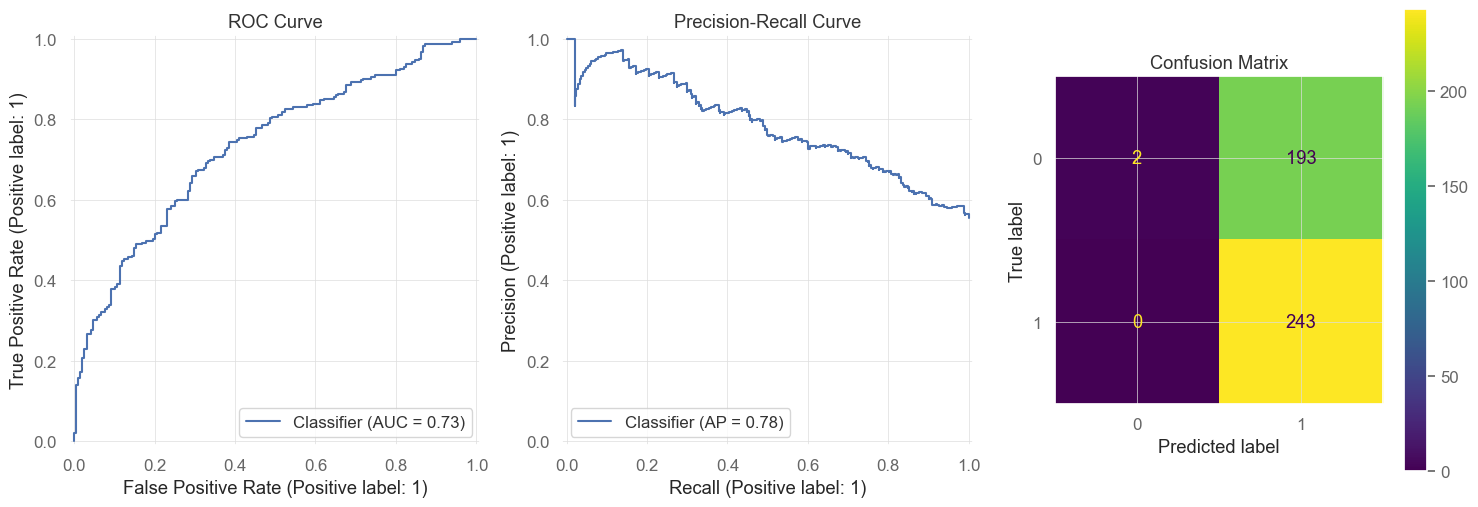

Model for DataFrame 2:
Log loss = 0.67924
AUC = 0.73268
Average Precision = 0.78349
Accuracy = 0.55936
Precision = 0.55734
Recall = 1.00000
F1 score = 0.71576

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       195
           1       0.56      1.00      0.72       243

    accuracy                           0.56       438
   macro avg       0.78      0.51      0.37       438
weighted avg       0.75      0.56      0.41       438



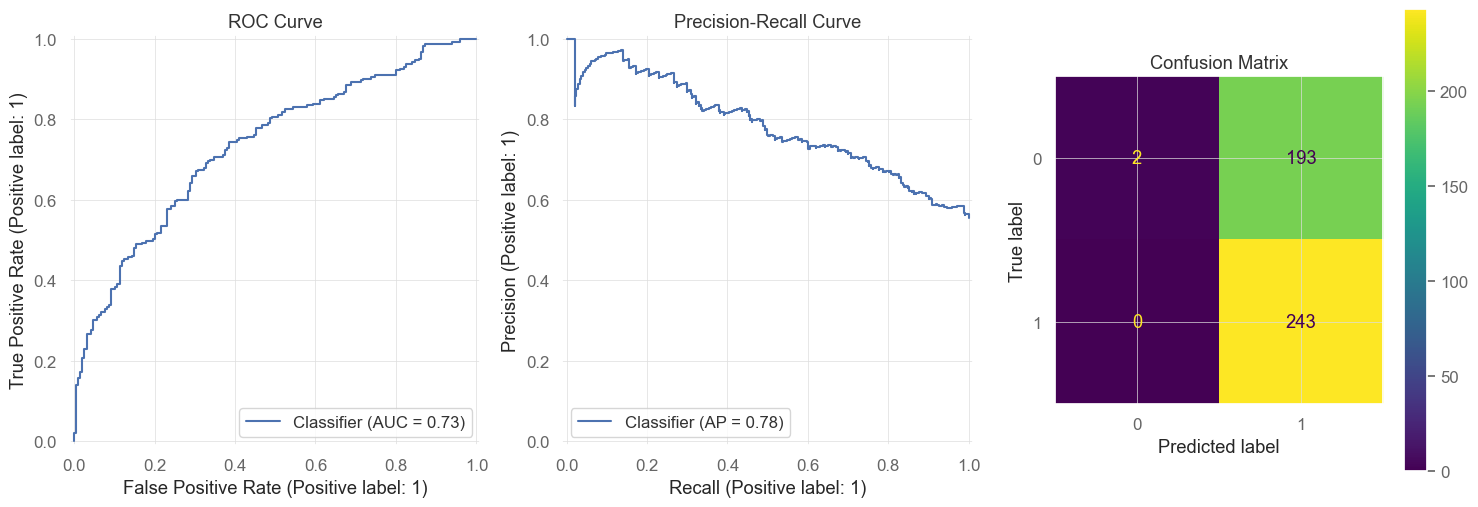

Model for DataFrame 3:
Log loss = 0.67924
AUC = 0.73268
Average Precision = 0.78349
Accuracy = 0.55936
Precision = 0.55734
Recall = 1.00000
F1 score = 0.71576

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       195
           1       0.56      1.00      0.72       243

    accuracy                           0.56       438
   macro avg       0.78      0.51      0.37       438
weighted avg       0.75      0.56      0.41       438



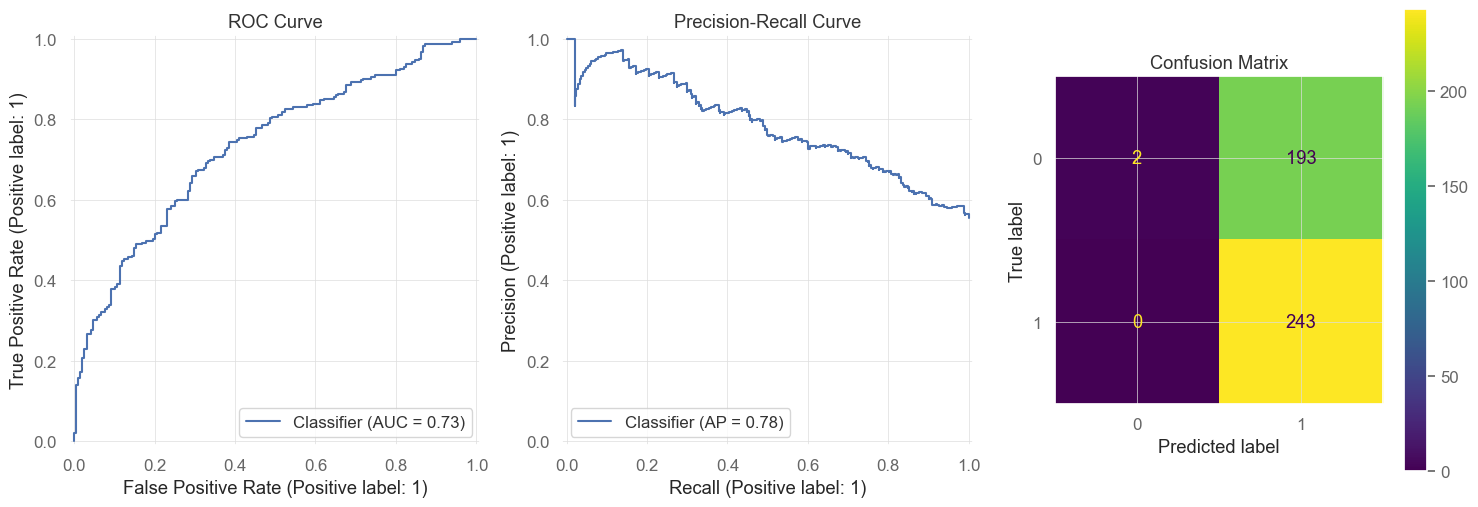

Model for DataFrame 4:
Log loss = 0.67924
AUC = 0.73268
Average Precision = 0.78349
Accuracy = 0.55936
Precision = 0.55734
Recall = 1.00000
F1 score = 0.71576

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       195
           1       0.56      1.00      0.72       243

    accuracy                           0.56       438
   macro avg       0.78      0.51      0.37       438
weighted avg       0.75      0.56      0.41       438



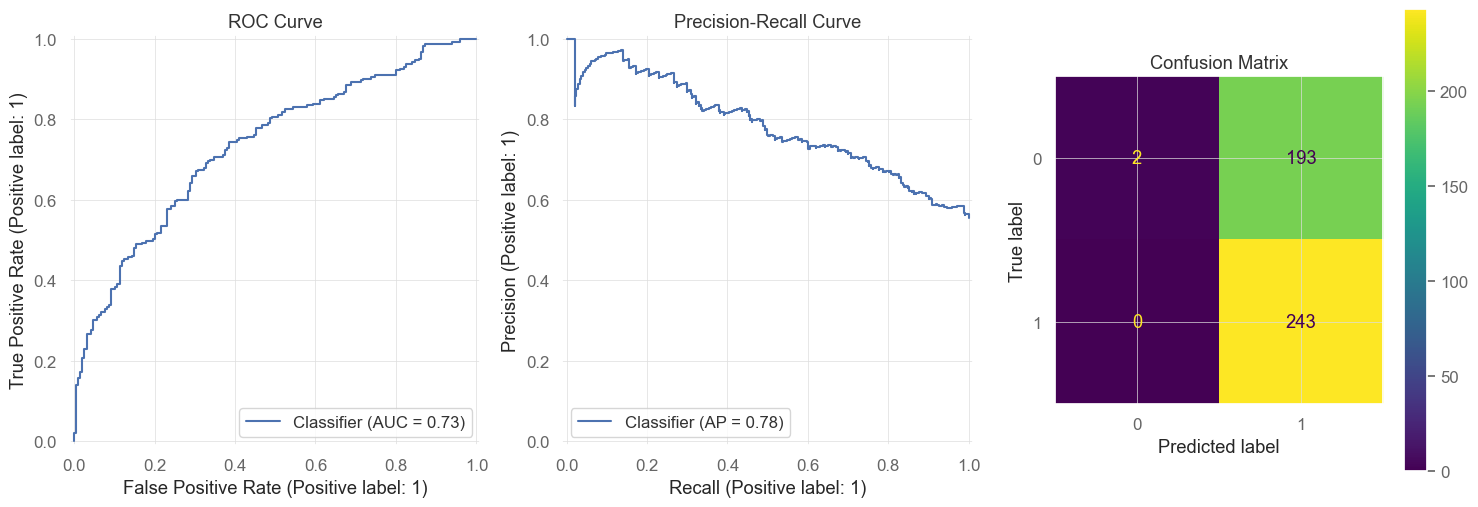

Model for DataFrame 5:
Log loss = 0.67924
AUC = 0.73268
Average Precision = 0.78349
Accuracy = 0.55936
Precision = 0.55734
Recall = 1.00000
F1 score = 0.71576

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       195
           1       0.56      1.00      0.72       243

    accuracy                           0.56       438
   macro avg       0.78      0.51      0.37       438
weighted avg       0.75      0.56      0.41       438



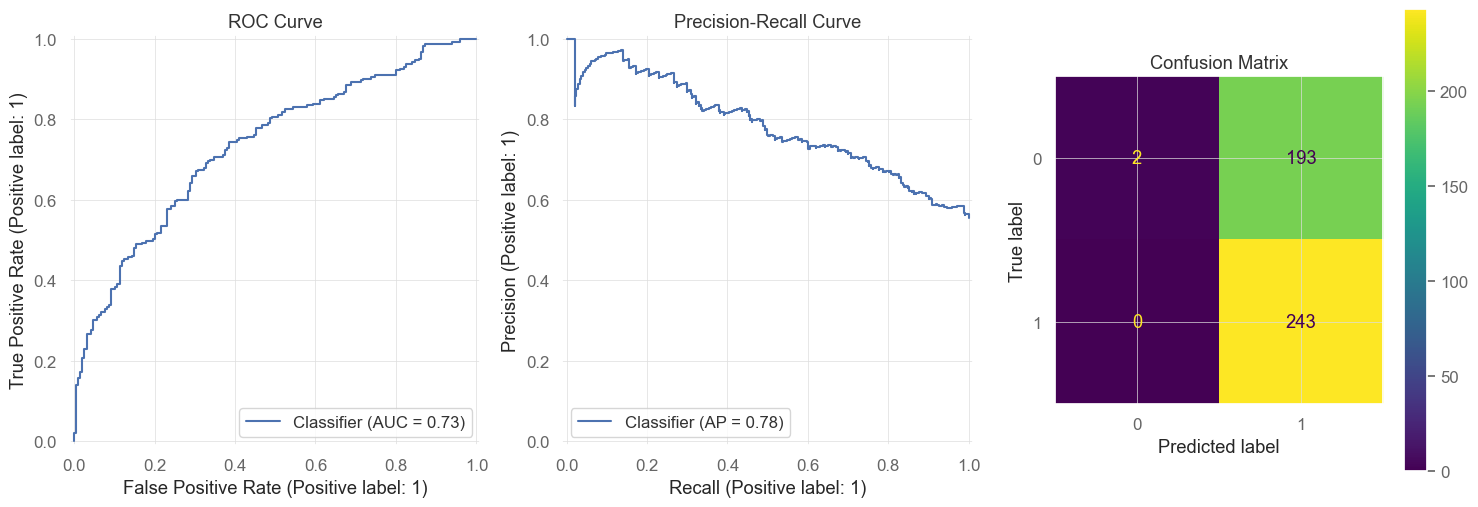

Model for DataFrame 6:
Log loss = 0.67924
AUC = 0.73268
Average Precision = 0.78349
Accuracy = 0.55936
Precision = 0.55734
Recall = 1.00000
F1 score = 0.71576

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       195
           1       0.56      1.00      0.72       243

    accuracy                           0.56       438
   macro avg       0.78      0.51      0.37       438
weighted avg       0.75      0.56      0.41       438



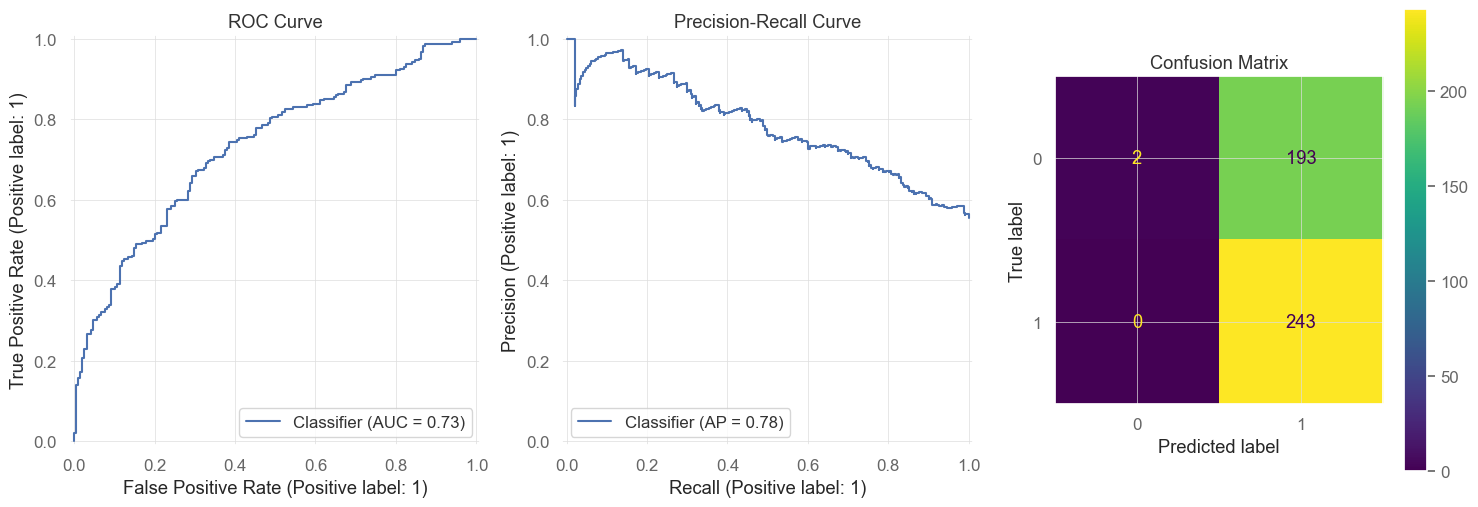

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Assuming ictlist is a list of your DataFrames
for index, ict in enumerate(ictlist):
    # Assume you've already split each DataFrame into df_train and df_test
    # And have defined numeric_cols and cat_cols
    # Initialize and fit scaler on training data
    scaler = StandardScaler().fit(df_train[numeric_cols])
    
    # Apply your get_features_and_target_arrays function here as needed
    # Fit the model on each DataFrame's training set
    clf = LogisticRegression(penalty='l2', C=0.00014, max_iter=100)
    clf.fit(X_train, y_train)
    
    # Make predictions and evaluate for each DataFrame's test set
    test_prob = clf.predict_proba(X_test)[:, 1]
    test_pred = clf.predict(X_test)
    
    # Printing evaluation metrics
    print(f'Model for DataFrame {index+1}:')
    print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
    print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
    print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
    print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))
    print('Precision = {:.5f}'.format(precision_score(y_test, test_pred)))
    print('Recall = {:.5f}'.format(recall_score(y_test, test_pred)))
    print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred)))
    print('\nClassification Report')
    print(classification_report(y_test, test_pred))
    
    # Plotting evaluation metrics
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    RocCurveDisplay.from_predictions(y_test, test_prob, ax=ax[0])
    ax[0].set_title('ROC Curve')
    PrecisionRecallDisplay.from_predictions(y_test, test_prob, ax=ax[1])
    ax[1].set_title('Precision-Recall Curve')
    ConfusionMatrixDisplay.from_predictions(y_test, test_pred, ax=ax[2])
    ax[2].set_title('Confusion Matrix')
    plt.show()

    # Note: Ensure you have appropriate definitions for X_train, y_train, X_test, y_test within your loop


Logistic Regrestion Model of 1m, 5m, 15m, 30m, 60m, 240m ES OHLC to predict Up or Down

In [54]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


In [55]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')


In [56]:
param_grid = {
    'n_estimators': [3],
    'learning_rate': [0.01],
    'max_depth': [5],
    'colsample_bytree': [0.7],
    'subsample':  [0.8]
}


In [57]:
grid_search = GridSearchCV(estimator=xgb_clf, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           n_jobs=4, 
                           cv=30, 
                           verbose=30000)


In [58]:
grid_search.fit(X_train, y_train)


Fitting 30 folds for each of 1 candidates, totalling 30 fits


GridSearchCV(cv=30,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.01],
                         'max_depth': [5], 'n_estimators': [3],
                         'subsample': [0.8]},
             scoring='accuracy', verbose=30000)

In [59]:
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Now you can use best_model for predictions
y_pred = best_model.predict(X_test)


Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 3, 'subsample': 0.8}


In [60]:
import joblib

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")


import pandas as pd

from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

models = {
    "Random Forest": RandomForestRegressor(
        min_samples_leaf=5, random_state=0, n_jobs=N_CORES
    ),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(
        max_leaf_nodes=15, random_state=0, early_stopping=False
    ),
}
param_grids = {
    "Random Forest": {"n_estimators": [10, 20, 50, 100]},
    "Hist Gradient Boosting": {"max_iter": [10, 20, 50, 100, 300, 500]},
}
cv = KFold(n_splits=4, shuffle=True, random_state=0)

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        cv=cv,
    ).fit(X_train, y_train)
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)

Number of physical cores: 12


In [88]:
ictlist3 = ictlist
ictlist3

[            const     Open     High      Low    Close  pump_move  dump_move  \
 ts_event                                                                      
 2021-02-02    1.0  3767.25  3767.75  3766.75  3767.25   0.000000   0.000000   
 2021-02-02    1.0  3767.00  3768.25  3767.00  3767.75   0.019910  -0.019910   
 2021-02-02    1.0  3767.75  3768.25  3766.75  3767.00  -0.019906   0.019906   
 2021-02-02    1.0  3767.00  3767.00  3765.75  3766.25  -0.019910   0.019910   
 2021-02-02    1.0  3766.25  3767.50  3766.25  3766.25   0.000000   0.000000   
 ...           ...      ...      ...      ...      ...        ...        ...   
 2022-02-01    1.0  4550.00  4550.25  4550.00  4550.25   0.005495  -0.005495   
 2022-02-01    1.0  4550.25  4550.75  4550.00  4550.50   0.005494  -0.005494   
 2022-02-01    1.0  4550.50  4550.75  4550.25  4550.75   0.005494  -0.005494   
 2022-02-01    1.0  4551.00  4551.00  4550.25  4551.00   0.000000   0.000000   
 2022-02-01    1.0  4551.00  4551.50  45

In [83]:
for ict in ictlist3:
    # Predefined list of numeric columns
    numeric_cols = ['Range', 'ADR', 'Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 5', 'RangeLag 1', 'RangeLag 2', 'RangeLag 3', 'RangeLag 4', 'RangeLag 5', 'Close', 'Open', 'High', 'Low']
    
    # Dynamically identify categorical columns by excluding numeric columns and the 'target' column
    cat_cols = list(set(ict.columns) - set(numeric_cols) - {'pump', 'dump'})
    cat_cols.sort()  # Sort the categorical columns for consistent ordering

    # Print the columns for each DataFrame
    print("Numeric columns:", numeric_cols)
    print("Categorical columns:", cat_cols)
    print()  # Adds an empty line for better readability between DataFrame outputs


Numeric columns: ['Range', 'ADR', 'Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 5', 'RangeLag 1', 'RangeLag 2', 'RangeLag 3', 'RangeLag 4', 'RangeLag 5', 'Close', 'Open', 'High', 'Low']
Categorical columns: ['const', 'dump_move', 'pump_move']

Numeric columns: ['Range', 'ADR', 'Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 5', 'RangeLag 1', 'RangeLag 2', 'RangeLag 3', 'RangeLag 4', 'RangeLag 5', 'Close', 'Open', 'High', 'Low']
Categorical columns: ['const', 'dump_move', 'pump_move']

Numeric columns: ['Range', 'ADR', 'Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 5', 'RangeLag 1', 'RangeLag 2', 'RangeLag 3', 'RangeLag 4', 'RangeLag 5', 'Close', 'Open', 'High', 'Low']
Categorical columns: ['const', 'dump_move', 'pump_move']

Numeric columns: ['Range', 'ADR', 'Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 5', 'RangeLag 1', 'RangeLag 2', 'RangeLag 3', 'RangeLag 4', 'RangeLag 5', 'Close', 'Open', 'High', 'Low']
Categorical columns: ['const', 'dump_move', 'pump_move']

Numeric columns: ['Range', 'ADR', 'Lag 1', '

In [89]:
X_train, X_test, y_train, y_test = {}, {}, {}, {}


In [93]:
X, y, y2 = {}, {}, {}
for i, df in enumerate(ictlist3):
    # Example feature selection - adjust based on your dataset
    X[i] = df.drop('dump', axis=1)
    y[i] = df['dump']
    y2[i] = df['pump']


In [94]:
from sklearn.model_selection import train_test_split

for i in range(len(ictlist3)):
    # Split the data
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X[i], y[i], test_size=0.2, random_state=1)


In [95]:
import xgboost as xgb

# Initialize dictionaries to store DMatrix objects
dtrain_reg, dtest_reg = {}, {}

for i in range(len(ictlist3)):
    # Note: X_train[i], y_train[i], X_test[i], and y_test[i] should already be defined from your previous split
    dtrain_reg[i] = xgb.DMatrix(X_train[i], label=y_train[i])  # For training data
    dtest_reg[i] = xgb.DMatrix(X_test[i], label=y_test[i])  # For testing data


In [102]:
# Assuming dtrain_reg is a dictionary of DMatrix objects, one for each DataFrame in ictlist3
params = {"objective": "reg:squarederror", "tree_method": "hist", "device": "cuda"}
n = 100

# Initialize a dictionary to store the models for each dataset
models = {}

for i, dtrain in dtrain_reg.items():
    model = xgb.train(
        params=params,
        dtrain=dtrain,  # Pass the DMatrix object for the current dataset
        num_boost_round=n,
    )
    # Store the trained model
    models[i] = model
    print(f"Model trained for dataset {i}")


Model trained for dataset 0
Model trained for dataset 1
Model trained for dataset 2
Model trained for dataset 3
Model trained for dataset 4
Model trained for dataset 5


In [103]:
from sklearn.metrics import mean_squared_error


In [104]:
# Initialize a dictionary to store the MSE for each dataset
mse_scores = {}

for i, dtest in dtest_reg.items():
    # Ensure that 'models' dictionary contains the model for the current dataset
    if i in models:
        # Use the model to make predictions on the test set
        preds = models[i].predict(dtest)
        
        # Calculate the MSE
        mse = mean_squared_error(dtest.get_label(), preds)
        mse_scores[i] = mse
        
        print(f"MSE for dataset {i}: {mse}")
    else:
        print(f"No model found for dataset {i}")


MSE for dataset 0: 1.7593113381050851e-12
MSE for dataset 1: 7.701089765888014e-12
MSE for dataset 2: 3.035438220222453e-11
MSE for dataset 3: 6.272268121554347e-11
MSE for dataset 4: 1.2735158760879273e-10
MSE for dataset 5: 5.317218887412878e-10


In [110]:
rmse_scores = {}
for i, dtest in dtest_reg.items():
    # Ensure we have the corresponding model and y_test data
    if i in models and i in y_test:
        # Make predictions using the model for dataset i
        preds = models[i].predict(dtest)
        
        # Calculate RMSE for the predictions against the true labels
        # Note: dtest.get_label() returns the true labels used in the DMatrix
        rmse = mean_squared_error(dtest.get_label(), preds, squared=False)
        
        print(f"RMSE for dataset {i}: {rmse:.3f}")
    else:
        print(f"Missing model or test data for dataset {i}")


RMSE for dataset 0: 0.000
RMSE for dataset 1: 0.000
RMSE for dataset 2: 0.000
RMSE for dataset 3: 0.000
RMSE for dataset 4: 0.000
RMSE for dataset 5: 0.000


c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporation\enigma\ict\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporation\enigma\ict\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporation\enigma\ict\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporati

In [125]:
params = {"objective": "reg:squarederror", "tree_method": 'hist', "device": "cuda"}
n = 88

In [126]:
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

In [127]:
import xgboost as xgb

# Assuming params and n are already defined
# params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
# n = 100

# Initialize a dictionary to store each trained model
models = {}

for i, dmatrix in dtrain_reg.items():
    # Assuming evals should include the corresponding test set in dtest_reg
    # Ensure evals is a list of tuples where each tuple is (DMatrix, label)
    evals = [(dmatrix, 'train'), (dtest_reg[i], 'test')]
    
    # Train the model
    model = xgb.train(
        params=params,
        dtrain=dmatrix,  # Use the current DMatrix
        num_boost_round=n,
        evals=evals,
        verbose_eval=8
    )
    
    # Store the model in the dictionary
    models[i] = model
    
    print(f"Model trained for dataset {i}")


[0]	train-rmse:0.34214	test-rmse:0.34227


[8]	train-rmse:0.01972	test-rmse:0.01973
[16]	train-rmse:0.00114	test-rmse:0.00114
[24]	train-rmse:0.00007	test-rmse:0.00007
[32]	train-rmse:0.00000	test-rmse:0.00000
[40]	train-rmse:0.00000	test-rmse:0.00000
[48]	train-rmse:0.00000	test-rmse:0.00000
[56]	train-rmse:0.00000	test-rmse:0.00000
[64]	train-rmse:0.00000	test-rmse:0.00000
[72]	train-rmse:0.00000	test-rmse:0.00000
[80]	train-rmse:0.00000	test-rmse:0.00000
[87]	train-rmse:0.00000	test-rmse:0.00000
Model trained for dataset 0
[0]	train-rmse:0.34852	test-rmse:0.34847
[8]	train-rmse:0.02009	test-rmse:0.02009
[16]	train-rmse:0.00116	test-rmse:0.00116
[24]	train-rmse:0.00007	test-rmse:0.00007
[32]	train-rmse:0.00000	test-rmse:0.00000
[40]	train-rmse:0.00000	test-rmse:0.00000
[48]	train-rmse:0.00000	test-rmse:0.00000
[56]	train-rmse:0.00000	test-rmse:0.00000
[64]	train-rmse:0.00000	test-rmse:0.00000
[72]	train-rmse:0.00000	test-rmse:0.00000
[80]	train-rmse:0.00000	test-rmse:0.00000
[87]	train-rmse:0.00000	test-rmse:0.00000
Model tra

In [34]:

# Initialize a list to store the fitted models
fitted_models = []

# Iterate over each pair of X and y
for X, y in zip(X1_clean, y1_clean):
    try:
        # Fit the logistic regression model
        model = sm.Logit(y, X).fit(disp=0)  # disp=0 suppresses the summary output during fitting
        # Append the fitted model to the list
        fitted_models.append(model)
    except Exception as e:
        # Append None or the error for models that fail to fit
        fitted_models.append(None)
        print(f"Model fitting failed: {e}")

In [37]:
for model in fitted_models:
    if model is not None:  # Ensure the model was fitted successfully
        print(model.summary())
    else:
        print("Model fitting failed for this dataset.")


                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:               525594
Model:                          Logit   Df Residuals:                   525588
Method:                           MLE   Df Model:                            5
Date:                Wed, 14 Feb 2024   Pseudo R-squ.:               0.0006295
Time:                        09:36:59   Log-Likelihood:            -3.0875e+05
converged:                       True   LL-Null:                   -3.0894e+05
Covariance Type:            nonrobust   LLR p-value:                 7.178e-82
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9719      0.003   -314.285      0.000      -0.978      -0.966
Lag 1         -2.5985      0.156    -16.638      0.000      -2.905      -2.292
Lag 2         -1.1429      0.155     -7.356      0.0

Introduce ADR

In [ ]:
for i in range(len(modified_series_list)):
    modified_series_list[i] = modified_series_list[i].dropna()


In [ ]:
modified_series_list = [df.dropna() for df in modified_series_list]


In [ ]:
# lag16model.summary()
lag8model.summary()

In [54]:
lag8predic = lag8model.predict(X1)

In [55]:
lag8predic

9       0.521508
10      0.592853
11      0.548126
12      0.508803
13      0.558361
          ...   
2166    0.648762
2187    0.496337
2188    0.624769
2189    0.630952
2190    0.517446
Length: 1077, dtype: float64

In [56]:
def confusion_matrix(act, pred):
    predictrans = ['Up' if i > 0.5 else 'Down' for i in pred]
    actuals = ['Up' if i > 0 else 'Down' for i in act]
    confusion_matrix = pd.crosstab(pd.Series(actuals), pd.Series(predictrans)
                                   ,rownames=['Actual'], colnames=['Predicted'])
    return confusion_matrix

In [58]:
confusion_matrix(y1, lag8predic)

Predicted,Down,Up
Actual,,
Down,51,437
Up,41,548


In [59]:
len(dff2)

1077

In [60]:
(51+548)/1077

0.5561745589600743

In [15]:
ict240data1['bisi_ce'] = np.where(
    ict240data1['bisi_high'] > ict240data1['bisi_low'],
    (ict240data1['bisi_high'] + ict240data1['bisi_low']) / 2,
    np.nan
)

In [16]:
ict240data1['sibi_ce'] = np.where(
    ict240data1['sibi_high'] > ict240data1['sibi_low'],
    (ict240data1['sibi_high'] + ict240data1['sibi_low']) / 2,
    np.nan
)

In [17]:
ict240data1.columns

Index(['Open', 'High', 'Low', 'Close', 'pump_move', 'dump_move', 'shigh_price',
       'slow_price', 'bisob_open', 'sibob_open', 'bisi_high', 'bisi_low',
       'sibi_low', 'sibi_high', 'dumpwickH', 'dumpwickO', 'pumpwickO',
       'pumpwickL', 'bisi_ce', 'sibi_ce'],
      dtype='object')

In [18]:
ict240data1['Pump'] = np.where(
    ict240data1['pump_move'] > 0,
    1,
    0
)

ict240data1['Dump'] = np.where(
    ict240data1['dump_move'] > 0,
    1,
    0
)

In [19]:
ict240data1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2191 entries, 2021-02-01 21:00:00 to 2022-02-01 21:00:00
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         2191 non-null   float64
 1   High         2191 non-null   float64
 2   Low          2191 non-null   float64
 3   Close        2191 non-null   float64
 4   pump_move    1569 non-null   float64
 5   dump_move    1569 non-null   float64
 6   shigh_price  314 non-null    float64
 7   slow_price   322 non-null    float64
 8   bisob_open   322 non-null    float64
 9   sibob_open   314 non-null    float64
 10  bisi_high    197 non-null    float64
 11  bisi_low     197 non-null    float64
 12  sibi_low     121 non-null    float64
 13  sibi_high    121 non-null    float64
 14  dumpwickH    704 non-null    float64
 15  dumpwickO    704 non-null    float64
 16  pumpwickO    850 non-null    float64
 17  pumpwickL    850 non-null    float64
 18  bisi_ce     

In [33]:
# Assuming your DataFrame is named `df`
# Drop the target columns from the features DataFrame
X = ict240data1.drop(['Pump', 'Dump'], axis=1)

# Keep the target columns in a separate DataFrame
y_pump = ict240data1['Pump']
y_dump = ict240data1['Dump']


In [34]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_pump, test_size=0.3,random_state=8888) # 70% training and 30% test


In [35]:
X


,Open,High,Low,Close,pump_move,dump_move,shigh_price,slow_price,bisob_open,sibob_open,bisi_high,bisi_low,sibi_low,sibi_high,dumpwickH,dumpwickO,pumpwickO,pumpwickL,bisi_ce,sibi_ce
ts_event,,,,,,,,,,,,,,,,,,,,
2021-02-01 21:00:00,3769.75,3770.00,3760.00,3767.25,-0.066317,0.066317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3770.00,3769.75,NaN,NaN,NaN,NaN
2021-02-02 01:00:00,3767.25,3792.00,3766.25,3785.00,0.471166,-0.471166,NaN,NaN,NaN,NaN,3792.0,3766.25,NaN,NaN,NaN,NaN,3767.25,3766.25,3779.125,NaN
2021-02-02 05:00:00,3785.00,3798.00,3781.00,3793.00,0.211361,-0.211361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3785.00,3781.00,NaN,NaN
2021-02-02 09:00:00,3793.00,3804.00,3791.50,3795.25,0.059320,-0.059320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3793.00,3791.50,NaN,NaN
2021-02-02 13:00:00,3795.25,3834.50,3794.50,3833.75,1.014426,-1.014426,NaN,NaN,NaN,NaN,3834.5,3794.50,NaN,NaN,NaN,NaN,3795.25,3794.50,3814.500,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01 05:00:00,4492.00,4514.50,4490.00,4509.00,0.378451,-0.378451,4514.5,NaN,NaN,4494.25,NaN,NaN,NaN,NaN,NaN,NaN,4492.00,4490.00,NaN,NaN
2022-02-01 09:00:00,4509.25,4510.25,4482.00,4499.75,-0.210678,0.210678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4510.25,4509.25,NaN,NaN,NaN,NaN
2022-02-01 13:00:00,4499.75,4515.00,4474.00,4511.50,0.261126,-0.261126,NaN,4474.0,4509.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4499.75,4474.00,NaN,NaN


In [36]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

# # Handling missing values (simple example, consider a better strategy for your case)
# X.fillna(X.mean(), inplace=True)  # Fill NaN with mean of each column. Adjust as needed.

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_pump, random_state=888)

# Initialize and train the classifier
clf = HistGradientBoostingClassifier(max_iter=100).fit(X_train, y_train)

# Evaluate accuracy on test set
print("Accuracy on test set:", clf.score(X_test, y_test))


Accuracy on test set: 0.9848


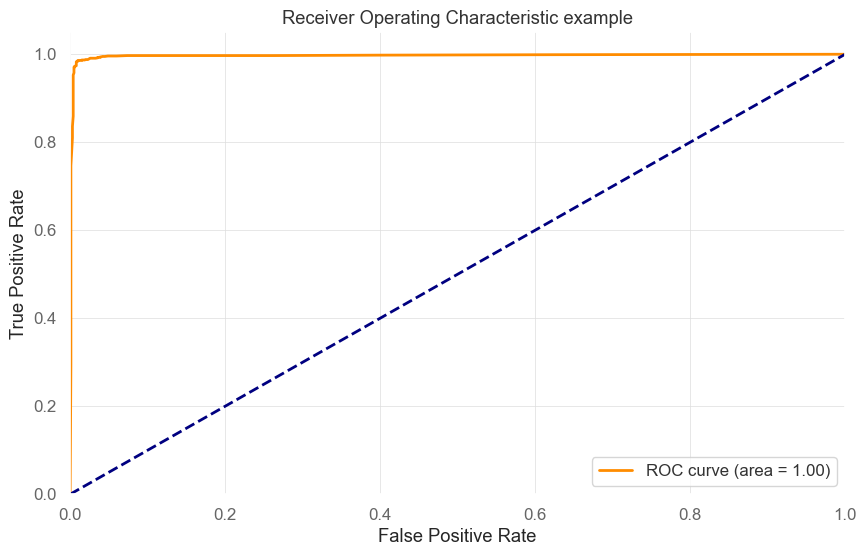

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Assuming 'X' is your feature set and 'y_pump' is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y_pump, test_size=0.2, random_state=888)

# Initialize and train your classifier
model = RandomForestClassifier(random_state=8)
model.fit(X_train, y_train)

# Predict probabilities for the positive class
y_score = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic example')
plt.legend(loc="lower right")
plt.show()


In [27]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

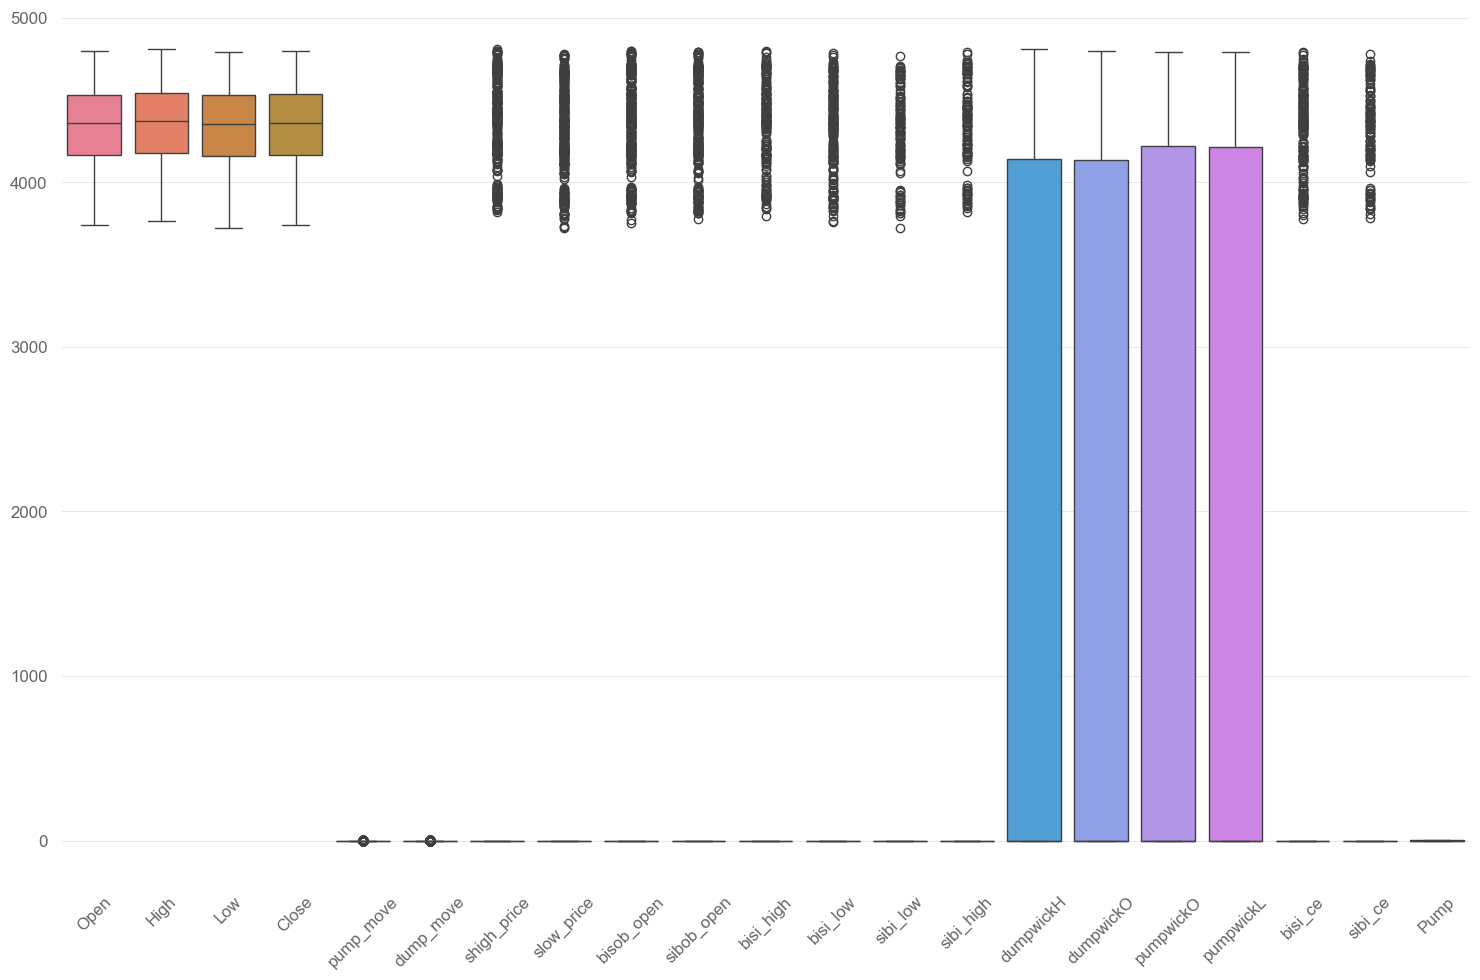

In [40]:


plt.figure(figsize=(15, 10))  # Set the figure size as needed
sbn.boxplot(data=ict240data1)
plt.xticks(rotation=45)  # Rotate the x labels if they are too long
plt.tight_layout()  # Adjust the layout
plt.show()  # Display the plot


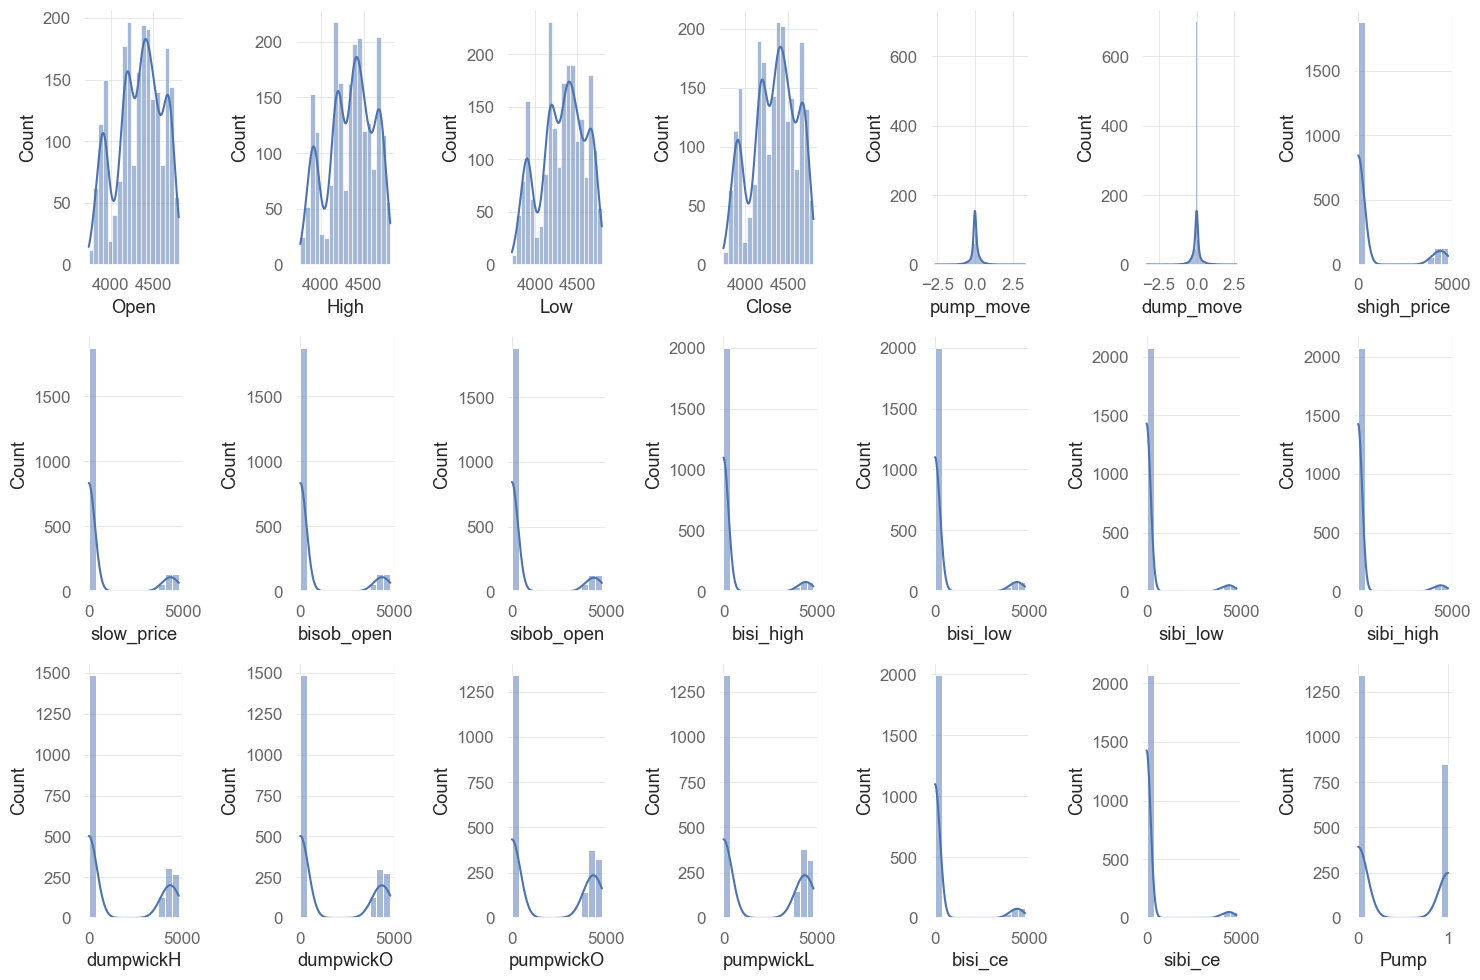

In [42]:
# Assuming `ict240data1` is your DataFrame with numerical columns only.
plt.figure(figsize=(15, 10))

for i, column in enumerate(ict240data1.columns, 1):
    plt.subplot(3, 7, i)  # Adjust the number of rows and columns as necessary
    sbn.histplot(ict240data1[column], kde=True)

plt.tight_layout()  # Adjust the layout
plt.show()  # Display the plot

In [26]:
from sklearn.preprocessing import MinMaxScaler

# Assuming `data` is your dataframe and you want to scale all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ict240data1)

In [28]:
scaled_data# Instantiate the MinMaxScaler
scaler = MinMaxScaler()

# Assuming that the user wants to scale all columns in the DataFrame
# This will scale all the features between 0 and 1
scaled_data = scaler.fit_transform(ict240data1)

# Create a DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=ict240data1.columns)

# Display the first few rows of the scaled DataFrame
scaled_df.head()

,Open,High,Low,Close,pump_move,dump_move,shigh_price,slow_price,bisob_open,sibob_open,...,bisi_low,sibi_low,sibi_high,dumpwickH,dumpwickO,pumpwickO,pumpwickL,bisi_ce,sibi_ce,Pump
0,0.026017,0.004077,0.036830,0.023652,0.432330,0.567670,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.784069,0.785487,0.000000,0.000000,0.000000,0.0,0.0
1,0.023652,0.025180,0.042657,0.040445,0.522618,0.477382,0.0,0.0,0.0,0.0,...,0.787548,0.0,0.0,0.000000,0.000000,0.785908,0.785781,0.789188,0.0,1.0
2,0.040445,0.030935,0.056410,0.048013,0.478975,0.521025,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.789611,0.788859,0.000000,0.0,1.0
3,0.048013,0.036691,0.066200,0.050142,0.453435,0.546565,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.791280,0.791049,0.000000,0.0,1.0
4,0.050142,0.065947,0.068998,0.086566,0.613877,0.386123,0.0,0.0,0.0,0.0,...,0.793455,0.0,0.0,0.000000,0.000000,0.791749,0.791675,0.796575,0.0,1.0


In [37]:
ict240num = ['Open', 'High', 'Low', 'Close', 'bisi_high', 'bisi_low', 'sibi_low', 'sibi_high', 'dumpwickH', 'dumpwickO', 'pumpwickO', 'pumpwickL']
ict240cat = list(set(ict240data1.columns) - set(ict240num) - {'Pump'})
ict240cat.sort()

print(ict240num)
print(ict240cat)

['Open', 'High', 'Low', 'Close', 'bisi_high', 'bisi_low', 'sibi_low', 'sibi_high', 'dumpwickH', 'dumpwickO', 'pumpwickO', 'pumpwickL']
['bisi_ce', 'bisob_open', 'dump_move', 'pump_move', 'shigh_price', 'sibi_ce', 'sibob_open', 'slow_price']


In [38]:
random_seed = 888
df_train, df_test = train_test_split(ict240data1, test_size=0.2, random_state=random_seed, stratify=ict240data1['Pump'])


print(df_train.shape)
print(df_test.shape)
print()
print(df_train['Pump'].value_counts(normalize=True))
print()
print(df_test['Pump'].value_counts(normalize=True))

(1752, 21)
(439, 21)

Pump
0    0.611872
1    0.388128
Name: proportion, dtype: float64

Pump
0    0.612756
1    0.387244
Name: proportion, dtype: float64


In [39]:

scaler = StandardScaler()
scaler.fit(df_train[ict240num])

def get_features_and_target_arrays(ict240data1, ict240num, ict240cat, scaler):
    X_numeric_scaled = scaler.transform(ict240data1[ict240num])
    X_categorical = ict240data1[ict240cat].to_numpy()
    X = np.hstack((X_categorical, X_numeric_scaled))
    y = ict240data1['Pump']
    return X, y

X, y = get_features_and_target_arrays(df_train, ict240num, ict240cat, scaler)

In [40]:
clf = LogisticRegression(penalty=None)  # C is set to a very large number
clf.fit(X, y)


LogisticRegression(penalty=None)

In [41]:
X_test, y_test = get_features_and_target_arrays(df_test, ict240num, ict240cat, scaler)

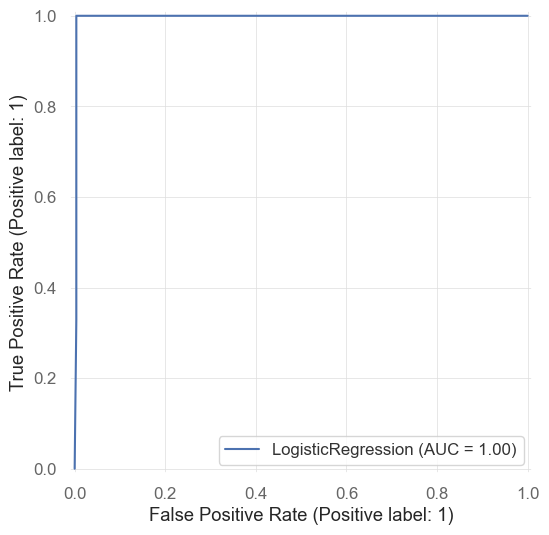

In [50]:


# Assuming clf is your trained logistic regression model, and X_test, y_test are your test datasets
ict240roc = RocCurveDisplay.from_estimator(clf, X_test, y_test)


In [43]:
from sklearn.metrics import PrecisionRecallDisplay

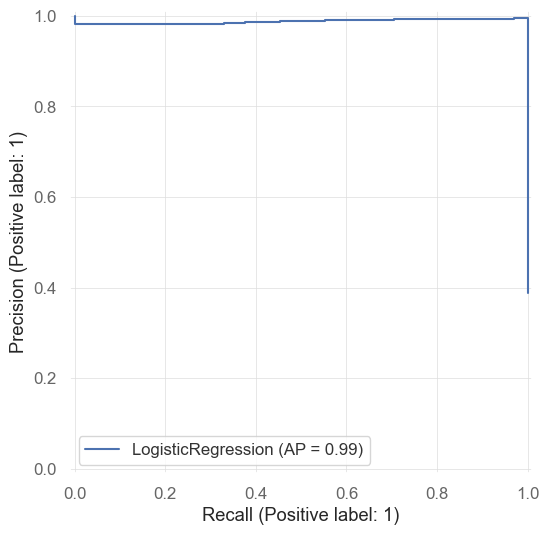

In [44]:
ict240precrec = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

In [46]:

test_prob = clf.predict_proba(X_test)[:, 1]
test_pred = clf.predict(X_test)

In [48]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score

In [49]:

print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred)))

print('\nClassification Report')
print(classification_report(y_test, test_pred))

Log loss = 0.08210
AUC = 0.99689
Average Precision = 0.98788

Using 0.5 as threshold:
Accuracy = 0.99772
Precision = 0.99415
Recall = 1.00000
F1 score = 0.99707

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       269
           1       0.99      1.00      1.00       170

    accuracy                           1.00       439
   macro avg       1.00      1.00      1.00       439
weighted avg       1.00      1.00      1.00       439



In [26]:
dff2.index = pd.to_datetime(dff2.index)


In [27]:
# For training data (before '2021-09-01')
x2_train = dff2[dff2.index < '2021-09-01'][['const', 'Lag 2', 'Lag 4', 'Lag 6', 'Lag 7', 'Lag 8']]
y2_train = dff2[dff2.index < '2021-09-01']['Direction']

# For testing data (on or after '2021-09-01')
x2_test = dff2[dff2.index >= '2021-09-01'][['const', 'Lag 2', 'Lag 4', 'Lag 6', 'Lag 7', 'Lag 8']]
y2_test = dff2[dff2.index >= '2021-09-01']['Direction']


In [28]:
lag8x2_model = sm.Logit(y2_train, x2_train).fit()


Optimization terminated successfully.
         Current function value: 0.685475
         Iterations 4


In [29]:
prediction = lag8x2_model.predict(x2_test)

In [30]:
confusion_matrix(y2_test, prediction)

Predicted
Actual


In [8]:
# Initialize ICT instances for each time frame
ict_instances = {
    "1": ICT(es1),
    "5": ICT(es5),
    "15": ICT(es15),
    "30": ICT(es30),
    "60": ICT(es60),
    "240": ICT(es240)
}

# List of methods to be called on each ICT instance
methods = [
    'pump', 'dump', 'shigh', 'slow', 'bisob', 'sibob', 'bisi', 'sibi', 'pwOpen', 'pwLow', 'dwHigh', 'dwOpen'
]

# Adjusted dictionary to store the final dataframes
ict_es = {}

# Loop through each ICT instance
for time_frame, ict_instance in ict_instances.items():
    # Step 1: Convert 'ts_event' to datetime with EST timezone
    
    # Step 2: Make 'ts_event' the index without removing timezone information
    ict_instance.data.set_index('ts_event', inplace=True)
    
    # Step 3: Rename columns to uppercase
    ict_instance.data.rename(columns={"open": "Open", "high": "High", "low": "Low", "close": "Close"}, inplace=True)
    
    # Apply all methods
    for method in methods:
        if hasattr(ict_instance, method):
            getattr(ict_instance, method)()  # Assuming each method modifies ict_instance.data
    
    # Store the final state of the data
    ict_es[time_frame] = ict_instance.data

# Now, ict_es dictionary contains the modified DataFrames for each time frame

KeyError: "None of ['ts_event'] are in the columns"

In [6]:

# Assuming ICT instances are initialized and methods list is defined

# Loop through each ICT instance
for time_frame, ict_instance in ict_instances.items():
    # Step 1: Convert 'ts_event' to datetime with EST timezone
    
    # Step 2: Make 'ts_event' the index without removing timezone information
    ict_instance.data.set_index('ts_event', inplace=True)
    
    # Step 3: Rename columns to uppercase
    ict_instance.data.rename(columns={"open": "Open", "high": "High", "low": "Low", "close": "Close"}, inplace=True)
    
    # Apply all methods
    for method in methods:
        if hasattr(ict_instance, method):
            getattr(ict_instance, method)()  # Assuming each method modifies ict_instance.data
    
    # Store the final state of the data
    ict_es[time_frame] = ict_instance.data

# Now, ict_es dictionary contains the modified DataFrames for each time frame


KeyError: 'close'

In [26]:
ictes1 = ict_es['1']

In [27]:
ictes1pct = ictes1['close'].pct_change() * 100

C:\Users\myrcene\AppData\Local\Temp\ipykernel_39832\138465170.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ictes1pct = ictes1['close'].pct_change() * 100


In [28]:
ictes1pct

0              NaN
1        -0.006634
2         0.006635
3        -0.006634
4        -0.013270
            ...   
525595    0.005495
525596    0.005494
525597    0.005494
525598    0.005494
525599    0.005493
Name: close, Length: 525600, dtype: float64

In [50]:
nan_placeholders = {}

for key, df in ict_instances.items():
    # Identify rows with NaNs across any column
    nan_indices = df.data.index[df.data.isna().any(axis=1)]
    
    # Store these indices in a dictionary for later reference
    nan_placeholders[key] = nan_indices


In [68]:
for key, ict_instance in ict_instances.items():
    ict_instance.data.dropna(inplace=True)


In [29]:
ict15 = ICT(es15)
ict

In [37]:

# List of methods to be applied (excluding those requiring arguments for simplicity)
methods_to_apply = [
    ict15.pump, ict15.dump, ict15.shigh, ict15.slow,
    ict15.bisob, ict15.sibob, ict15.bisi, ict15.sibi,
    ict15.dumpwickHO, ict15.pumpwickOL
]

# Apply each method
for method in methods_to_apply:
    method()

# Apply methods that require arguments
ict15.label_trade_outcomes(look_forward_periods=3)

# Retrieve the enhanced DataFrame
ict15data = ict15.data


In [39]:
# Split 'dumpwickHO' into 'dumpwickH' and 'dumpwickO' and convert to float
ict15data[['dumpwickH', 'dumpwickO']] = ict15data['dumpwickHO'].str.split(',', expand=True).astype(float)

# Split 'pumpwickOL' into 'pumpwickO' and 'pumpwickL' and convert to float
ict15data[['pumpwickO', 'pumpwickL']] = ict15data['pumpwickOL'].str.split(',', expand=True).astype(float)

# Drop the original 'dumpwickHO' and 'pumpwickOL' columns
ict15data.drop(['dumpwickHO', 'pumpwickOL'], axis=1, inplace=True)

# Verify the result
print(ict15data[['dumpwickH', 'dumpwickO', 'pumpwickO', 'pumpwickL']].head())


   dumpwickH  dumpwickO  pumpwickO  pumpwickL
0     3770.0    3769.75        NaN        NaN
1        NaN        NaN    3761.50    3760.00
2        NaN        NaN    3761.50    3760.00
3        NaN        NaN    3766.50    3763.75
4        NaN        NaN    3767.25    3766.25


In [97]:
ict15data

,ts_event,open,high,low,close,pump_move,dump_move,shigh_price,slow_price,bisob_open,...,pumpwickL,Target,swinghigh,swinglow,bisob,sibob,bisi,sibi,dumpwick,pumpwick
0,2021-02-02 00:00:00,3769.75,3770.00,3760.25,3761.75,-0.212216,0.212216,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,0,1,0
1,2021-02-02 00:15:00,3761.50,3765.25,3760.00,3761.75,0.006646,-0.006646,NaN,NaN,NaN,...,3760.00,1,0,0,0,0,0,0,0,1
2,2021-02-02 00:30:00,3761.50,3767.25,3760.00,3766.50,0.132926,-0.132926,NaN,NaN,NaN,...,3760.00,1,0,0,0,0,0,0,0,1
3,2021-02-02 00:45:00,3766.50,3767.25,3763.75,3767.25,0.019912,-0.019912,NaN,NaN,NaN,...,3763.75,1,0,0,0,0,0,0,0,1
4,2021-02-02 01:00:00,3767.25,3773.25,3766.25,3772.75,0.145995,-0.145995,NaN,NaN,NaN,...,3766.25,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2022-02-01 22:45:00,4550.75,4554.00,4549.50,4549.50,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,0,0,0
35036,2022-02-01 23:00:00,4552.00,4552.25,4547.00,4548.75,-0.071397,0.071397,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,0,1,0
35037,2022-02-01 23:15:00,4548.75,4552.25,4548.50,4551.75,0.065952,-0.065952,NaN,NaN,NaN,...,4548.50,1,0,0,0,0,0,0,0,1
35038,2022-02-01 23:30:00,4551.75,4552.25,4548.50,4552.25,0.010985,-0.010985,NaN,NaN,NaN,...,4548.50,1,0,0,0,0,0,0,0,1


In [52]:
ict15data1 = ict15data

In [ ]:

# Assuming 'ict15data1' is your DataFrame
# Replace the following line with the code to load your data
# ict15data1 = pd.read_csv('your_data_file.csv')

# List of columns to plot
columntoplot = ['open', 'high', 'low', 'close', 'pump_move', 'dump_move', 'shigh_price', 'slow_price', 
                   'bisob_open', 'bisi_high', 'bisi_low', 'sibi_low', 'sibi_high', 'profit_after_n', 
                   'optimal_exit_period', 'dumpwickH', 'dumpwickO', 'pumpwickO', 'pumpwickL']

# Plotting
fig, ax = plt.subplots(len(columntoplot), 1, figsize=(10, 5 * len(columntoplot)))
fig.tight_layout(pad=5.0)

for i, column in enumerate(columntoplot):
    # Skip plotting for columns with all NaN values
    if ict15data1[column].isna().all():
        continue
    ict15data1[column].dropna().hist(ax=ax[i], bins=50)
    ax[i].set_title(f'Distribution of {column}')
    ax[i].set_xlabel(column)
    ax[i].set_ylabel('Frequency')

plt.show()


In [51]:
# Convert 'ts_event' to datetime with UTC timezone
ict15data['ts_event'] = pd.to_datetime(ict15data['ts_event'], utc=True)

# Now convert the timezone-aware datetime to timezone-naive (removing timezone information)
ict15data['ts_event'] = ict15data['ts_event'].dt.tz_convert(None)


In [54]:
ict15data['Target'] = np.where(ict15data['pump_move'] > 0, 1, 0)

In [ ]:
['open', 'high', 'low', 'close', 'pump_move', 'dump_move', 'shigh_price', 'slow_price', 
                   'bisob_open', 'bisi_high', 'bisi_low', 'sibi_low', 'sibi_high', 'profit_after_n', 
                   'optimal_exit_period', 'dumpwickH', 'dumpwickO', 'pumpwickO', 'pumpwickL']

In [55]:
ict15data['swinghigh'] = np.where(
    ict15data['shigh_price'] > 0, 1, 0
)

ict15data['swinglow'] = np.where(
    ict15data['slow_price'] > 0, 1, 0
)

ict15data['bisob'] = np.where(
    ict15data['bisob_open'] > 0, 1, 0
)

ict15data['sibob'] = np.where(
    ict15data['sibob_open'] > 0, 1, 0
)

ict15data['bisi'] = np.where((ict15data['bisi_high'] > 0) & (ict15data['bisi_low'] > 0), 1, 0)

ict15data['sibi'] = np.where((ict15data['sibi_high'] > 0) & (ict15data['sibi_low'] > 0), 1, 0)

ict15data['dumpwick'] = np.where((ict15data['dumpwickH'] > 0) & (ict15data['dumpwickO'] > 0), 1, 0)

ict15data['pumpwick'] = np.where((ict15data['pumpwickO'] > 0) & (ict15data['pumpwickL'] > 0), 1, 0)



In [59]:
ict15data[['open', 'high', 'low', 'close']] = ict15data[['open', 'high', 'low', 'close']].fillna(method='ffill')
ict15data3 = ict15data

C:\Users\myrcene\AppData\Local\Temp\ipykernel_24452\2083923154.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ict15data[['open', 'high', 'low', 'close']] = ict15data[['open', 'high', 'low', 'close']].fillna(method='ffill')


In [76]:
ict15nonan = ict15data.drop(['shigh_price', 'slow_price', 'bisob_open', 'bisi_high', 'bisi_low', 'sibi_low', 'sibob_open', 'sibi_high', 'dumpwickH', 'optimal_exit_period', 'profit_after_n', 'dumpwickO', 'pumpwickO', 'pumpwickL', 'pump_move', 'dump_move'], axis=1)

In [92]:
ict15nonan

,const,ts_event,open,high,low,close,Target,swinghigh,swinglow,bisob,sibob,bisi,sibi,dumpwick,pumpwick
0,1.0,2021-02-02 00:00:00,3769.75,3770.00,3760.25,3761.75,0,0,0,0,0,0,0,1,0
1,1.0,2021-02-02 00:15:00,3761.50,3765.25,3760.00,3761.75,1,0,0,0,0,0,0,0,1
2,1.0,2021-02-02 00:30:00,3761.50,3767.25,3760.00,3766.50,1,0,0,0,0,0,0,0,1
3,1.0,2021-02-02 00:45:00,3766.50,3767.25,3763.75,3767.25,1,0,0,0,0,0,0,0,1
4,1.0,2021-02-02 01:00:00,3767.25,3773.25,3766.25,3772.75,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,1.0,2022-02-01 22:45:00,4550.75,4554.00,4549.50,4549.50,0,0,0,0,0,0,0,0,0
35036,1.0,2022-02-01 23:00:00,4552.00,4552.25,4547.00,4548.75,0,0,0,0,0,0,0,1,0
35037,1.0,2022-02-01 23:15:00,4548.75,4552.25,4548.50,4551.75,1,0,0,0,0,0,0,0,1
35038,1.0,2022-02-01 23:30:00,4551.75,4552.25,4548.50,4552.25,1,0,0,0,0,0,0,0,1


In [82]:
ict15nonan = sm.add_constant(ict15nonan)

In [83]:
ict15nonan

,const,ts_event,open,high,low,close,Target,swinghigh,swinglow,bisob,sibob,bisi,sibi,dumpwick,pumpwick
0,1.0,2021-02-02 00:00:00,3769.75,3770.00,3760.25,3761.75,0,0,0,0,0,0,0,1,0
1,1.0,2021-02-02 00:15:00,3761.50,3765.25,3760.00,3761.75,1,0,0,0,0,0,0,0,1
2,1.0,2021-02-02 00:30:00,3761.50,3767.25,3760.00,3766.50,1,0,0,0,0,0,0,0,1
3,1.0,2021-02-02 00:45:00,3766.50,3767.25,3763.75,3767.25,1,0,0,0,0,0,0,0,1
4,1.0,2021-02-02 01:00:00,3767.25,3773.25,3766.25,3772.75,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,1.0,2022-02-01 22:45:00,4550.75,4554.00,4549.50,4549.50,0,0,0,0,0,0,0,0,0
35036,1.0,2022-02-01 23:00:00,4552.00,4552.25,4547.00,4548.75,0,0,0,0,0,0,0,1,0
35037,1.0,2022-02-01 23:15:00,4548.75,4552.25,4548.50,4551.75,1,0,0,0,0,0,0,0,1
35038,1.0,2022-02-01 23:30:00,4551.75,4552.25,4548.50,4552.25,1,0,0,0,0,0,0,0,1


In [93]:
X = ict15nonan[['const', 'swinghigh', 'swinglow', 'bisob', 'sibob', 'bisi', 'sibi', 'dumpwick', 'pumpwick', 'open', 'high', 'low', 'close']]    

In [94]:
y = ict15nonan.Target

In [95]:
model = sm.Logit(y,X)

In [96]:
result = model.fit()

         Current function value: inf
         Iterations: 35


c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporation\enigma\ict\lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporation\enigma\ict\lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporation\enigma\ict\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\myrcene\Documents\qwantss\Longest Holdings Corporation\enigma\ict\lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(

LinAlgError: Singular matrix

In [27]:
# Assuming df_15 is your 15-minute timeframe DataFrame
# Make sure both DataFrames have the same datetime index
df_15_minute_features = ict15data.resample('1T').ffill().shift(-look_forward_window)


,ts_event,open,high,low,close,pump_move,dump_move,shigh_price,slow_price,bisob_open,...,bisi_low,sibi_low,sibi_high,profit_after_n,optimal_exit_period,dumpwickH,dumpwickO,pumpwickO,pumpwickL,optimal_hold
0,2021-02-02 00:00:00,3769.75,3770.00,3767.75,3768.25,-0.039790,0.039790,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,2.0,3770.0,3769.75,NaN,NaN,2.0
1,2021-02-02 00:01:00,3768.00,3769.25,3767.25,3768.00,0.000000,0.000000,NaN,3767.25,3769.75,...,NaN,NaN,NaN,0.000066,1.0,NaN,NaN,NaN,NaN,1.0
2,2021-02-02 00:02:00,3768.00,3768.50,3767.50,3768.25,0.006635,-0.006635,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.000066,1.0,NaN,NaN,3768.00,3767.50,1.0
3,2021-02-02 00:03:00,3768.25,3768.50,3767.00,3768.00,-0.006634,0.006634,NaN,3767.00,3768.00,...,NaN,NaN,NaN,-0.000066,3.0,3768.5,3768.25,NaN,NaN,3.0
4,2021-02-02 00:04:00,3768.00,3768.00,3767.25,3767.50,-0.013270,0.013270,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000066,2.0,3768.0,3768.00,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525595,2022-02-01 23:55:00,4550.00,4550.25,4550.00,4550.25,0.005495,-0.005495,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000165,3.0,NaN,NaN,4550.00,4550.00,NaN
525596,2022-02-01 23:56:00,4550.25,4550.75,4550.00,4550.50,0.005494,-0.005494,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000165,3.0,NaN,NaN,4550.25,4550.00,NaN
525597,2022-02-01 23:57:00,4550.50,4550.75,4550.25,4550.75,0.005494,-0.005494,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,4550.50,4550.25,NaN
525598,2022-02-01 23:58:00,4551.00,4551.00,4550.25,4551.00,0.000000,0.000000,NaN,NaN,NaN,...,4550.25,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN


In [73]:
# Assuming df_1min and df_15min already exist and have correct datetime indices
# Aggregate 1-minute pump values to 15-minute intervals
# This example simply takes the mean of the pump values within each 15-minute interval
pump_15min = resulting_dfs['1_pump'].resample('15T').mean()  # 'T' stands for minute; '15T' for 15-minute intervals


C:\Users\myrcene\AppData\Local\Temp\ipykernel_38136\416134838.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pump_15min = resulting_dfs['1_pump'].resample('15T').mean()  # 'T' stands for minute; '15T' for 15-minute intervals


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [47]:

X = sm.add_constant(X)

In [48]:
y= es1[['close']]
X= es15[['close','pump_move']]

In [49]:
lin_reg = sm.OLS(y,X)

MissingDataError: exog contains inf or nans

In [59]:
# def set_lead_stats(row):
#     if row['current_stat'] == 'None':
#         return row['statuslead']
#     else:
#         return row['current_stat']
    
# df['status'] = df.apply(set_lead_stats, axis=1) 
ict60d['dumpwickHO'] = np.where(
    ict60d['dump_move'] > 0,
    ict60d['high'].astype(str) + ',' + ict60d['open'].astype(str),  # Concatenate 'high' and 'low' with a comma
    'Nan'
)

In [60]:
ict60d['pumpwickOL'] = np.where(
    ict60d['dump_move'] > 0,
    ict60d['open'].astype(str) + ',' + ict60d['low'].astype(str),  # Concatenate 'high' and 'low' with a comma
    'Nan'
)

,ts_event,open,high,low,close,pump_move,dump_move,shigh_price,slow_price,bisob_open,sibob_open,bisi_high,bisi_low,sibi_low,sibi_high,dumpwick,dumpwickHL
0,2021-02-01 19:00:00-05:00,3769.75,3770.00,3760.00,3767.25,-0.066317,0.066317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3770.0,3760.0","3770.0,3769.75"
1,2021-02-01 20:00:00-05:00,3767.25,3787.75,3766.25,3786.00,0.497711,-0.497711,NaN,NaN,NaN,NaN,3787.75,3766.25,NaN,NaN,Nan,Nan
2,2021-02-01 21:00:00-05:00,3786.00,3792.00,3781.25,3787.00,0.026413,-0.026413,3792.0,NaN,NaN,3767.25,NaN,NaN,NaN,NaN,Nan,Nan
3,2021-02-01 22:00:00-05:00,3787.25,3787.75,3783.25,3786.75,-0.013202,0.013202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3787.75,3783.25","3787.75,3787.25"
4,2021-02-01 23:00:00-05:00,3786.75,3787.75,3783.00,3785.00,-0.046214,0.046214,NaN,3783.0,3787.25,NaN,NaN,NaN,NaN,NaN,"3787.75,3783.0","3787.75,3786.75"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-02-01 14:00:00-05:00,4508.75,4513.25,4500.00,4509.00,0.005545,-0.005545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nan,Nan
8756,2022-02-01 15:00:00-05:00,4509.00,4541.00,4507.25,4534.00,0.554447,-0.554447,NaN,NaN,NaN,NaN,4541.00,4507.25,NaN,NaN,Nan,Nan
8757,2022-02-01 16:00:00-05:00,4534.25,4554.75,4533.25,4549.50,0.336329,-0.336329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nan,Nan
8758,2022-02-01 17:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nan,Nan


In [32]:

# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Use maximum width available


In [30]:

# Construct a DataFrame from the boolean arrays
conditions_df = pd.DataFrame({
    'pump': a1,
    'dump': a2,
    'shigh': a3,
    'slow': a4,
    'bisob': a5,
    'sibob': a6,
    'bisi': a7,
    'sibi': a8
})

# Compute the correlation matrix
correlation_matrix = conditions_df.corr()

# Display the correlation matrix
print(correlation_matrix)


           pump      dump     shigh      slow     bisob     sibob      bisi  \
pump   1.000000 -0.467264  0.143828  0.084249  0.084249  0.143828  0.387823   
dump  -0.467264  1.000000  0.103328  0.170963  0.170963  0.103328 -0.181083   
shigh  0.143828  0.103328  1.000000 -0.054169 -0.054169  1.000000 -0.000757   
slow   0.084249  0.170963 -0.054169  1.000000  1.000000 -0.054169 -0.031171   
bisob  0.084249  0.170963 -0.054169  1.000000  1.000000 -0.054169 -0.031171   
sibob  0.143828  0.103328  1.000000 -0.054169 -0.054169  1.000000 -0.000757   
bisi   0.387823 -0.181083 -0.000757 -0.031171 -0.031171 -0.000757  1.000000   
sibi  -0.170760  0.364908 -0.024184  0.013603  0.013603 -0.024184 -0.066265   

           sibi  
pump  -0.170760  
dump   0.364908  
shigh -0.024184  
slow   0.013603  
bisob  0.013603  
sibob -0.024184  
bisi  -0.066265  
sibi   1.000000  


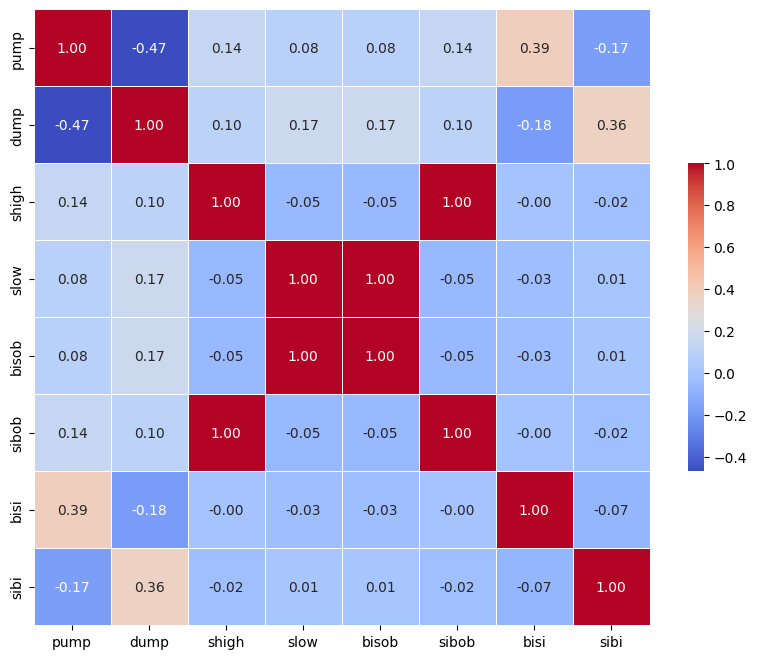

In [31]:


# Assuming your correlation matrix is stored in `correlation_matrix`

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sbn.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


In [52]:
es60

,Open,High,Low,Close
ts_event,,,,
2021-02-02 00:00:00,3769.75,3770.00,3760.00,3767.25
2021-02-02 01:00:00,3767.25,3787.75,3766.25,3786.00
2021-02-02 02:00:00,3786.00,3792.00,3781.25,3787.00
2021-02-02 03:00:00,3787.25,3787.75,3783.25,3786.75
2021-02-02 04:00:00,3786.75,3787.75,3783.00,3785.00
...,...,...,...,...
2022-02-01 18:00:00,4509.00,4511.50,4500.00,4509.00
2022-02-01 19:00:00,4508.75,4513.25,4500.00,4509.00
2022-02-01 20:00:00,4509.00,4541.00,4507.25,4534.00


In [59]:
# Check index type
print(f"Index type: {type(es60.index)}")

# Verify index is in chronological order
print(f"Index is chronological: {es60.index.is_monotonic_increasing}")
# Check for missing values
print(es60.isnull().sum())
# Temporarily set display precision (for viewing, does not alter data)
pd.set_option('display.precision', 2)

# Print a sample to inspect
print(es60.head())
# Check for duplicate timestamps
print(f"Number of duplicate timestamps: {es60.index.duplicated().sum()}")



Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index is chronological: True
Open     0
High     0
Low      0
Close    0
dtype: int64
                        Open     High      Low    Close
ts_event                                               
2021-02-02 00:00:00  3769.75  3770.00  3760.00  3767.25
2021-02-02 01:00:00  3767.25  3787.75  3766.25  3786.00
2021-02-02 02:00:00  3786.00  3792.00  3781.25  3787.00
2021-02-02 03:00:00  3787.25  3787.75  3783.25  3786.75
2021-02-02 04:00:00  3786.75  3787.75  3783.00  3785.00
Number of duplicate timestamps: 0


          Open     High      Low    Close
count  5918.00  5918.00  5918.00  5918.00
mean   4329.69  4334.49  4324.49  4329.81
std     263.68   263.58   263.70   263.60
min    3721.00  3747.25  3720.50  3721.25
25%    4161.25  4165.25  4156.75  4161.50
50%    4356.88  4363.75  4351.50  4356.88
75%    4534.50  4538.25  4529.50  4534.50
max    4805.00  4808.25  4802.25  4805.25


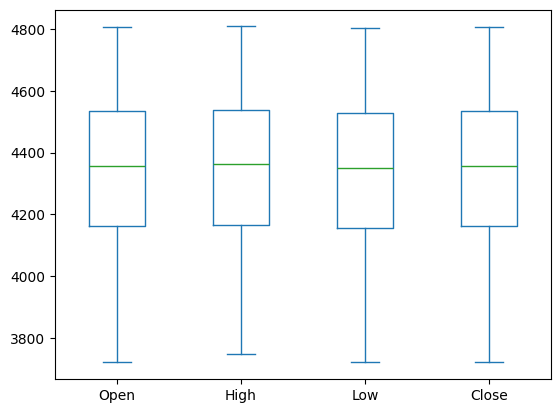

In [56]:
# Descriptive statistics
print(es60.describe())

# Optionally, use visualizations to spot outliers
import matplotlib.pyplot as plt

es60[['Open', 'High', 'Low', 'Close']].plot(kind='box')
plt.show()


In [43]:
a1 = ict60.pump()
a2 =ict60.dump()
a3 = ict60.shigh()
a4 = ict60.slow()
a5 = ict60.bisob()
a6 = ict60.sibob()
a7 = ict60.bisi()
a8 = ict60.sibi()

print(a1)

0       False
1        True
2        True
3       False
4       False
        ...  
8755     True
8756     True
8757     True
8758    False
8759    False
Length: 8760, dtype: bool


In [63]:
class RsiOscillator(Strategy):
    upper_bound = 70
    lower_bound = 30

    def init(self):
        self.rsi = self.I(talib.RSI, self.data.Close, 14)

    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.position.close()

        elif crossover(self.lower_bound, self.rsi):
            self.buy()



In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [40]:
import statsmodels.api as sm

In [41]:
df = pd.DataFrame(es60)

In [ ]:
x = df[[]]

In [ ]:
x = df[[]]